In [42]:
pip install sweetviz imblearn


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
import sweetviz as sv
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.optimizers import Adam


#EDA

In [44]:
df = pd.read_csv('framingham.csv')


                                             |          | [  0%]   00:00 -> (? left)


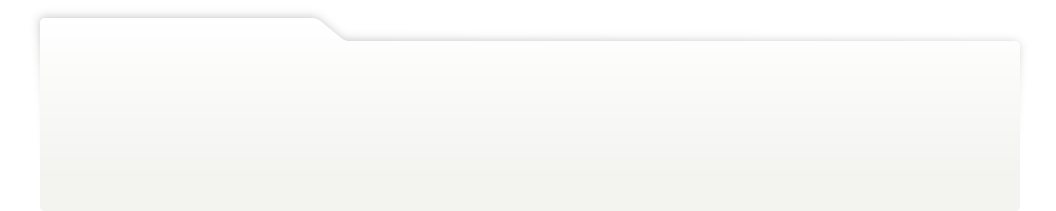
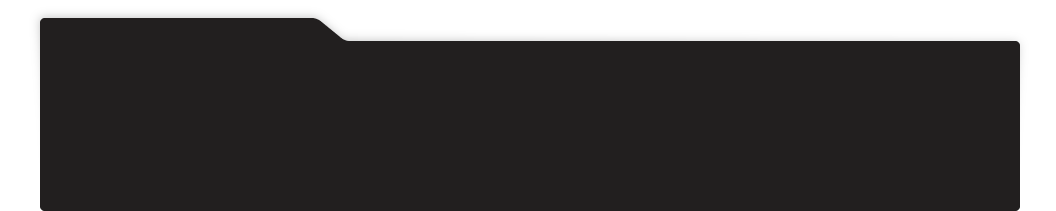
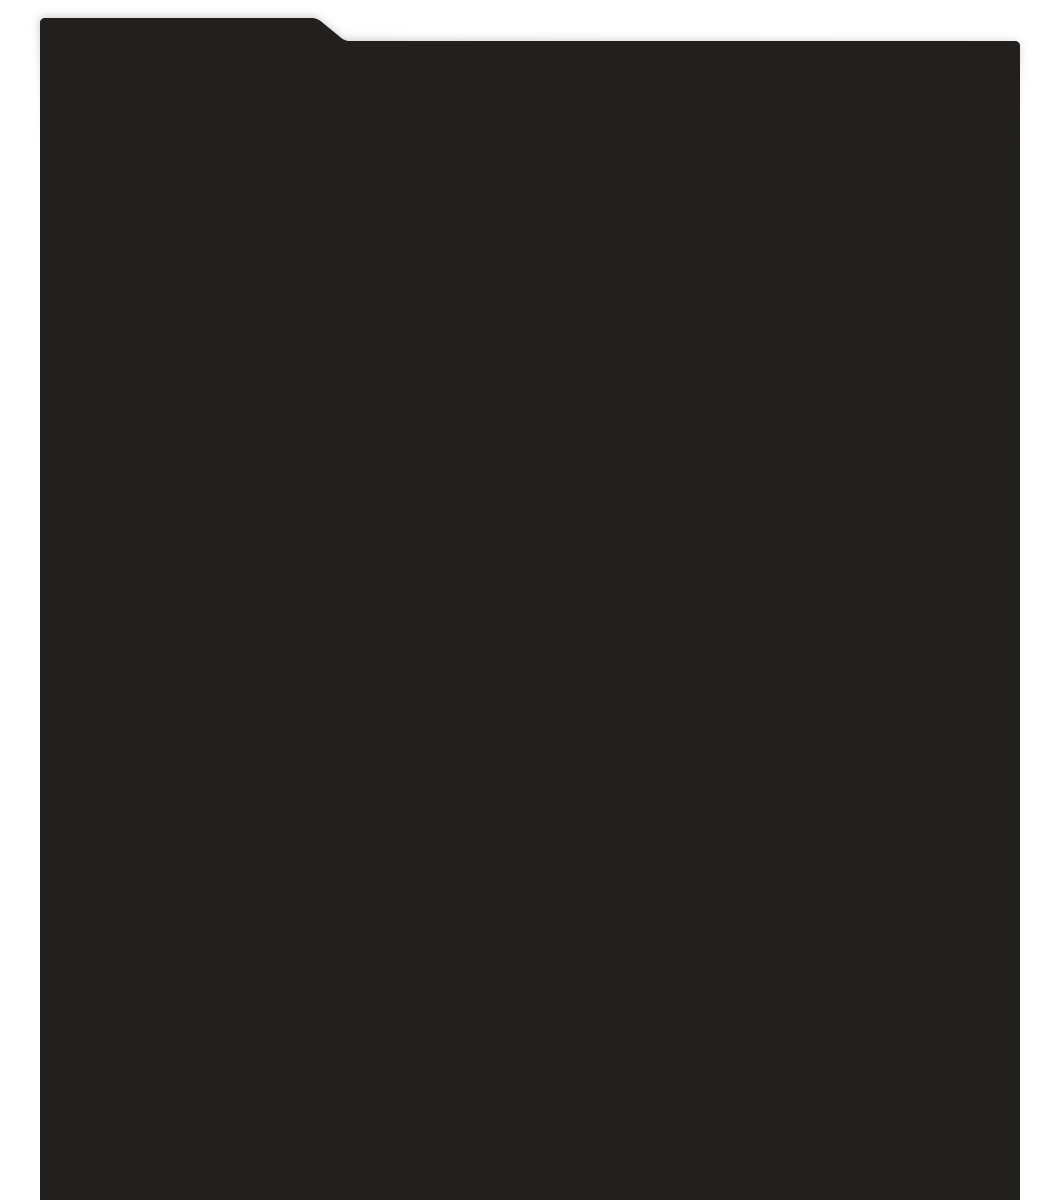
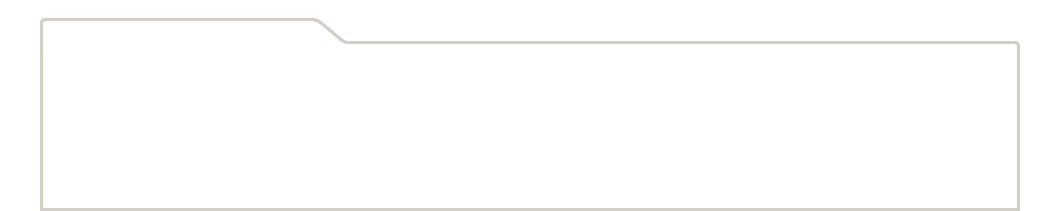
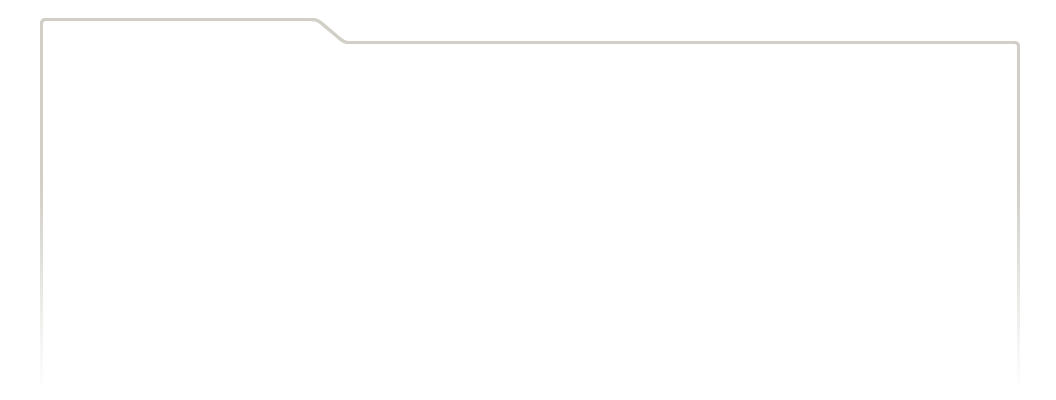
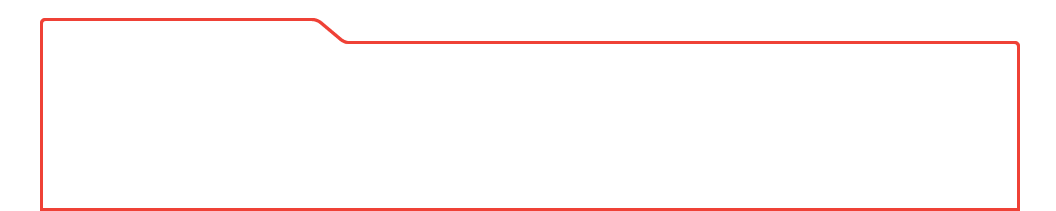
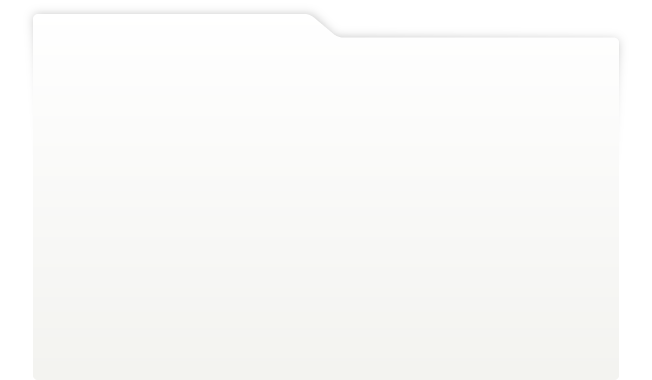
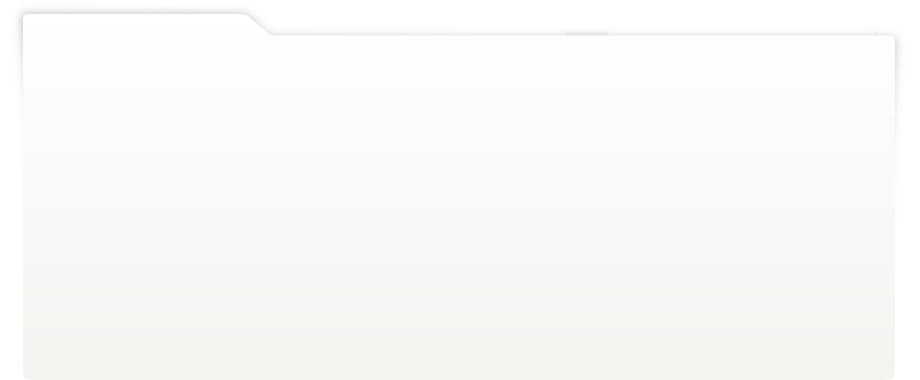
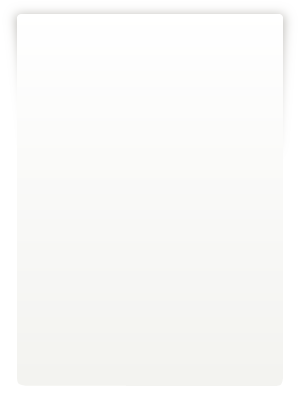
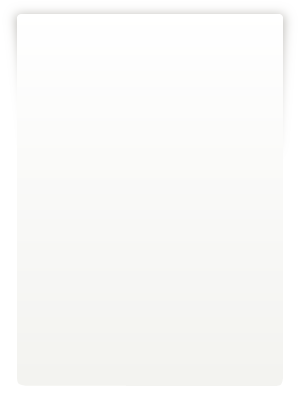
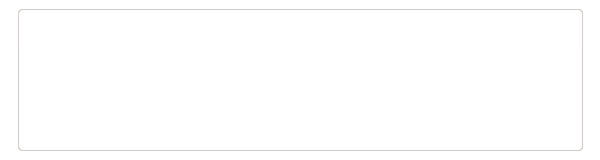
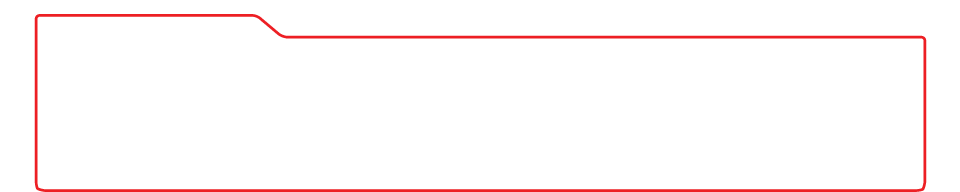
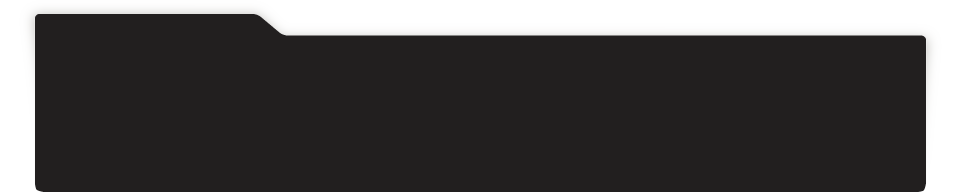
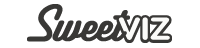
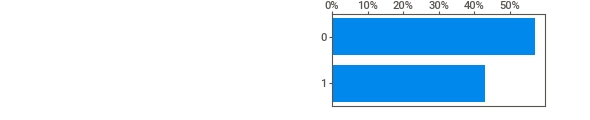
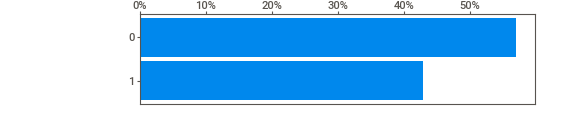
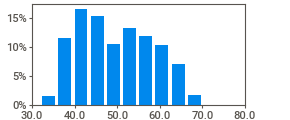
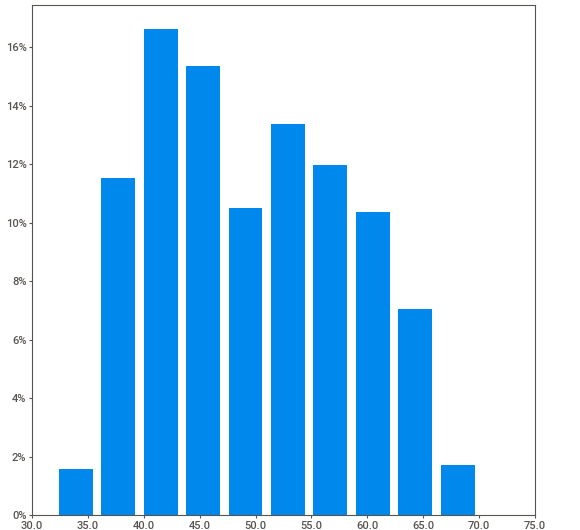
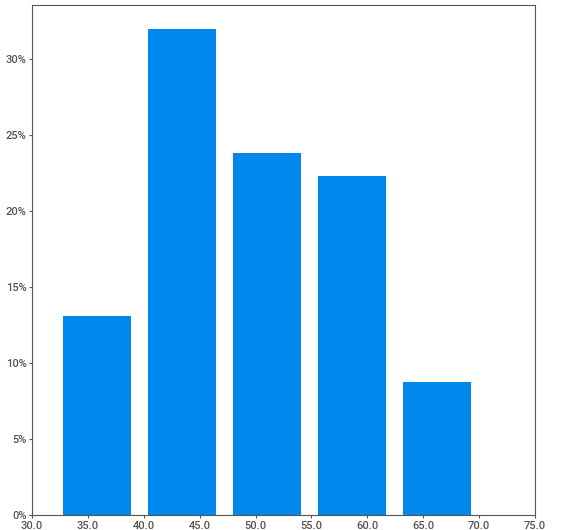
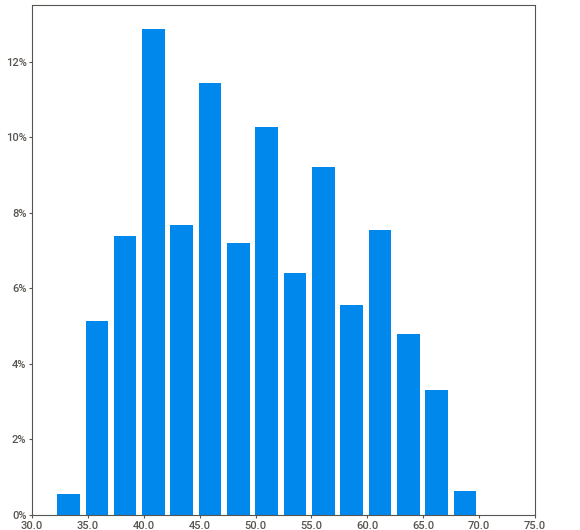
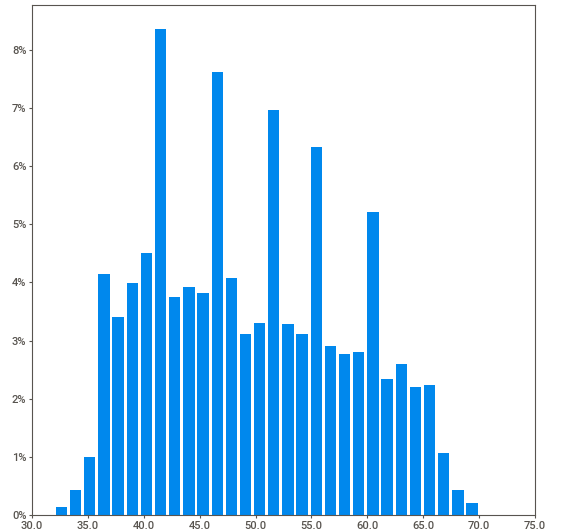
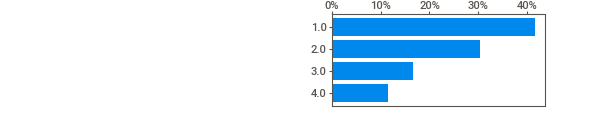
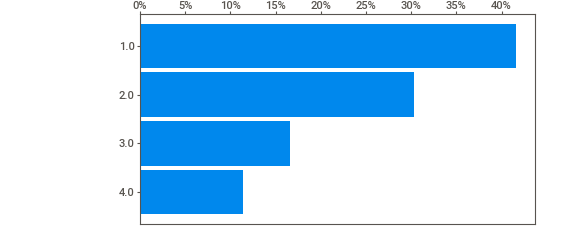
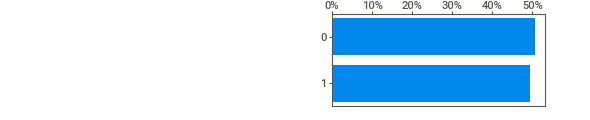
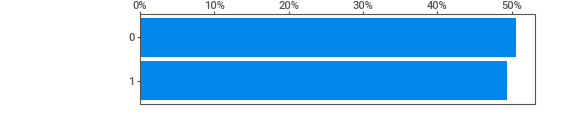
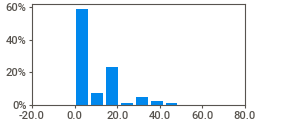
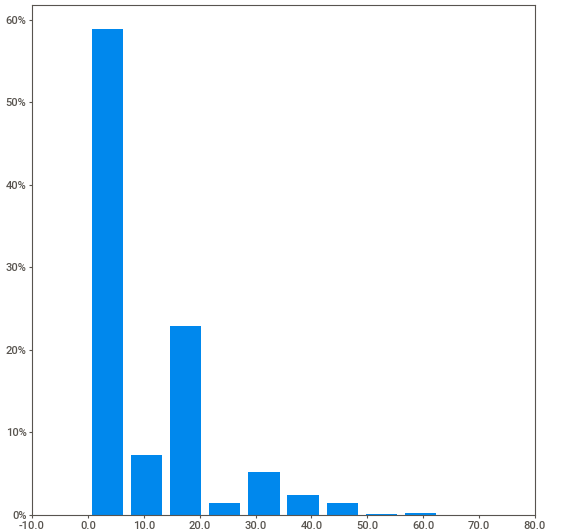
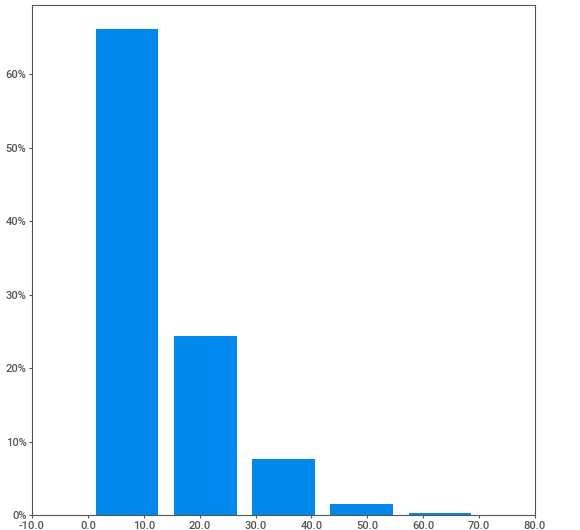
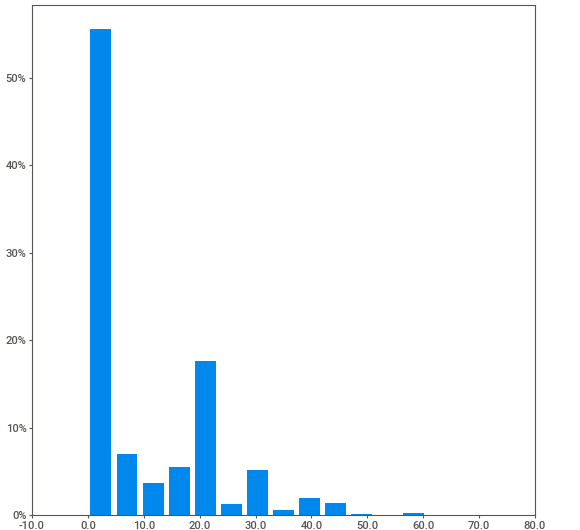
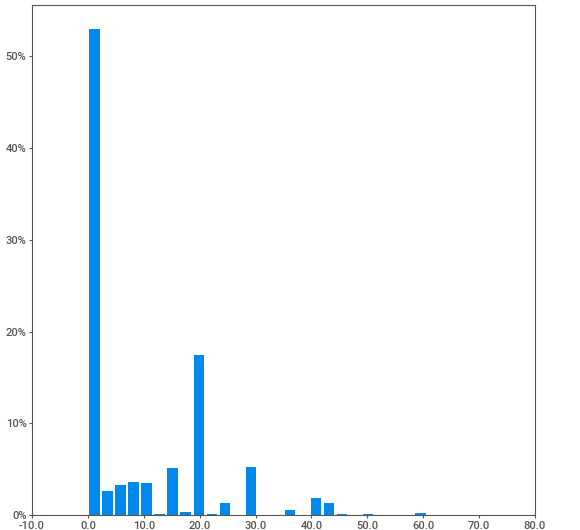
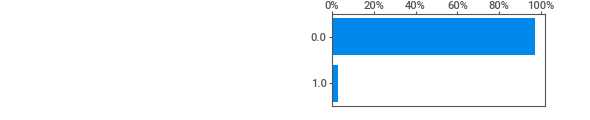
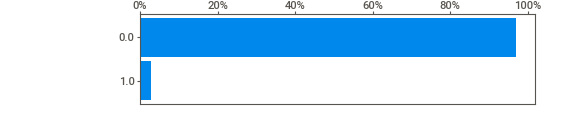
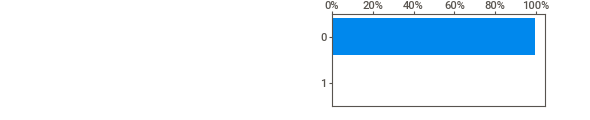
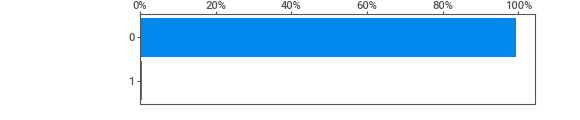
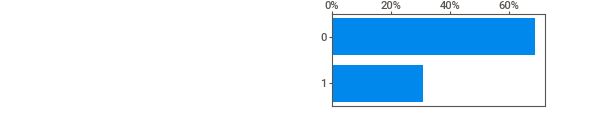
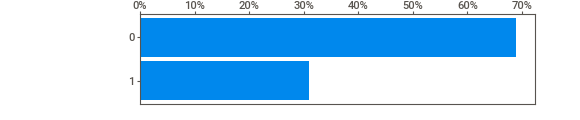
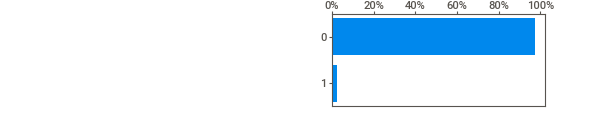
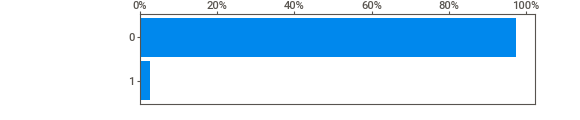
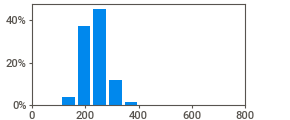
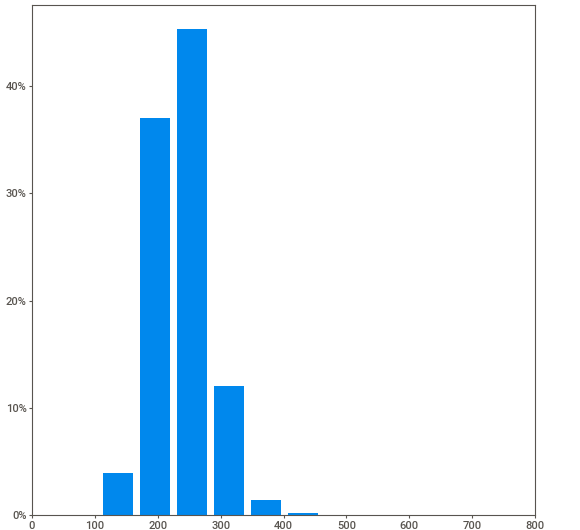
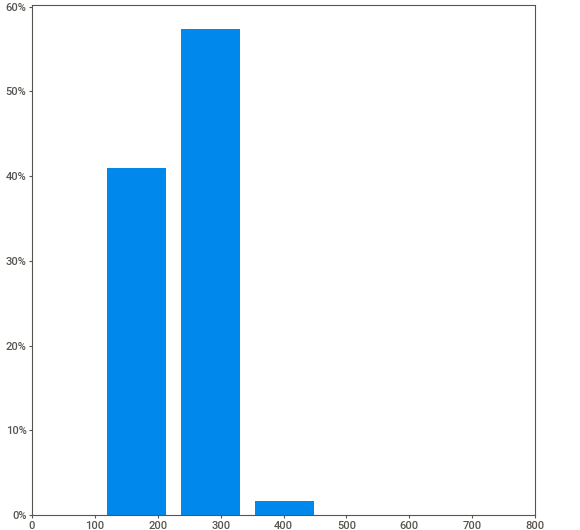
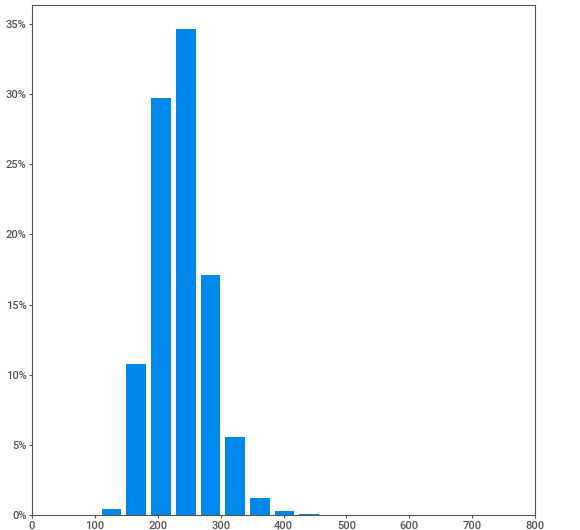
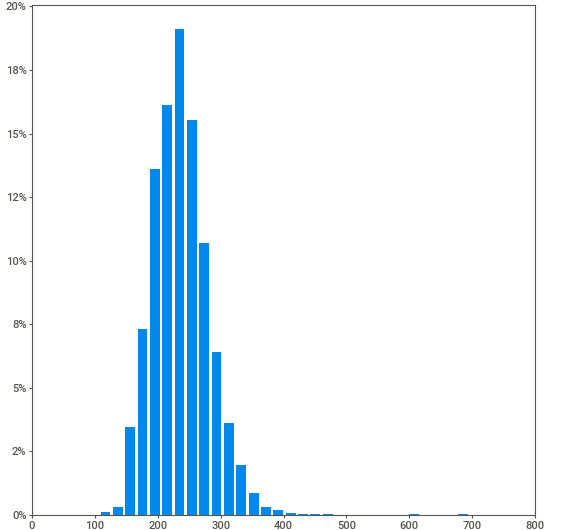
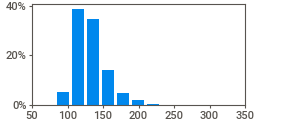
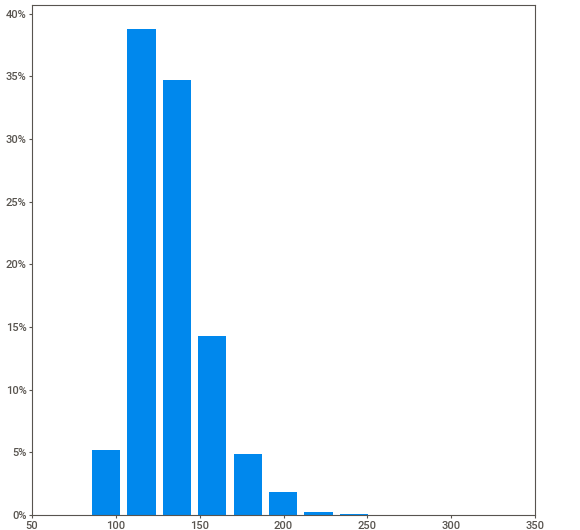
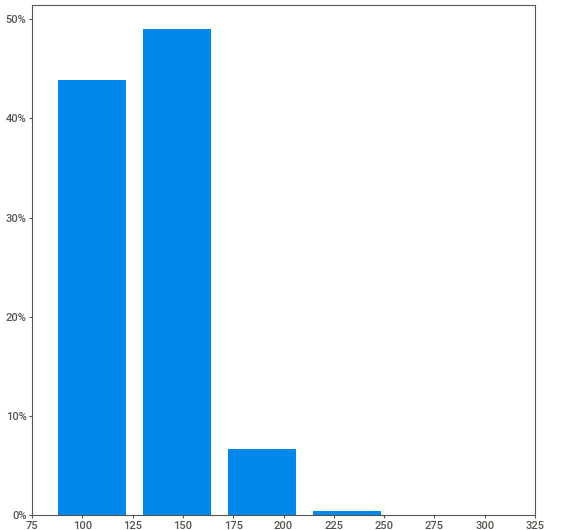
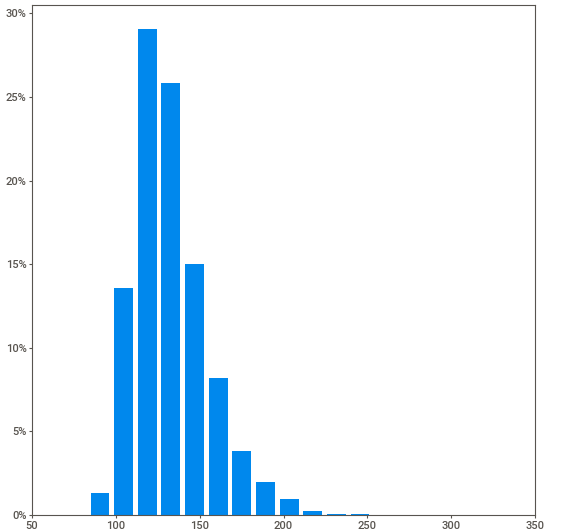
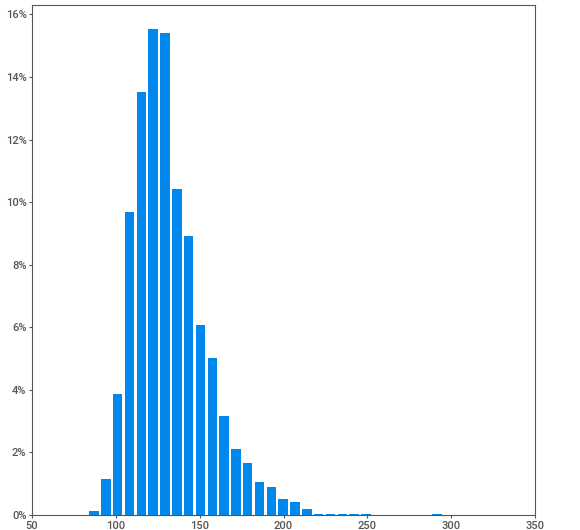
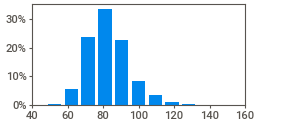
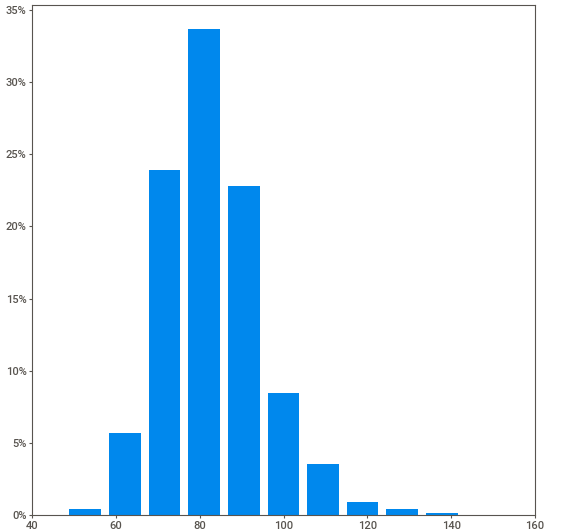
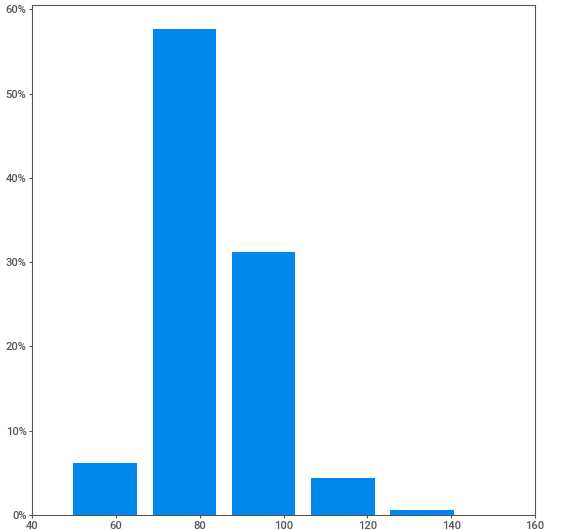
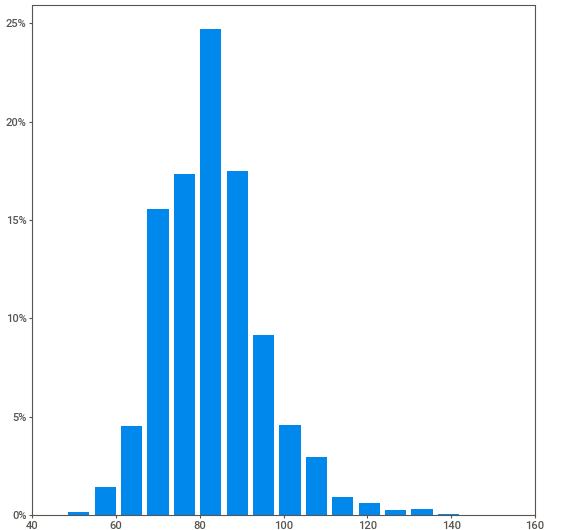
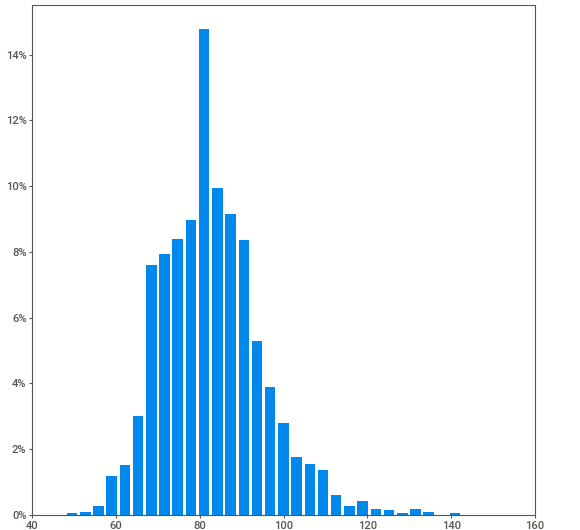
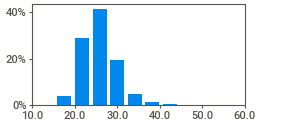
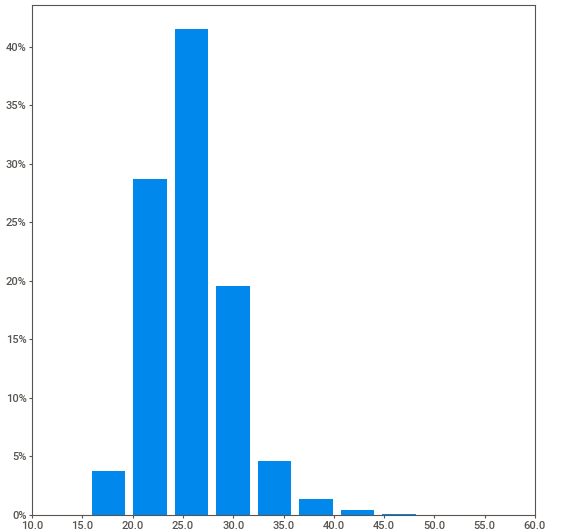
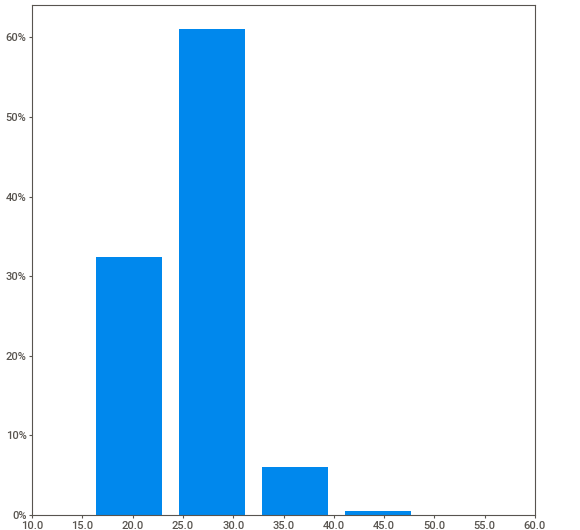
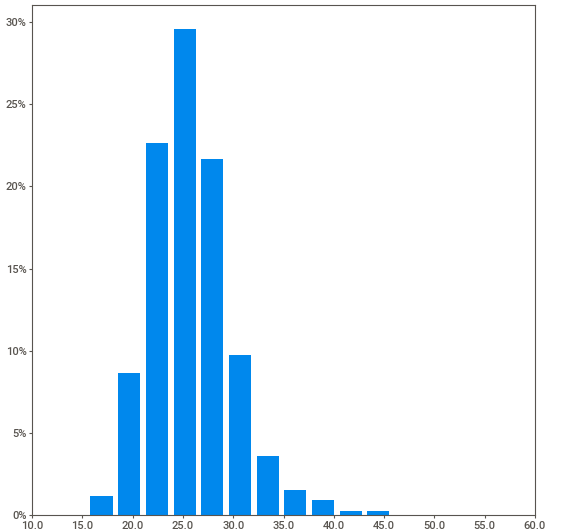
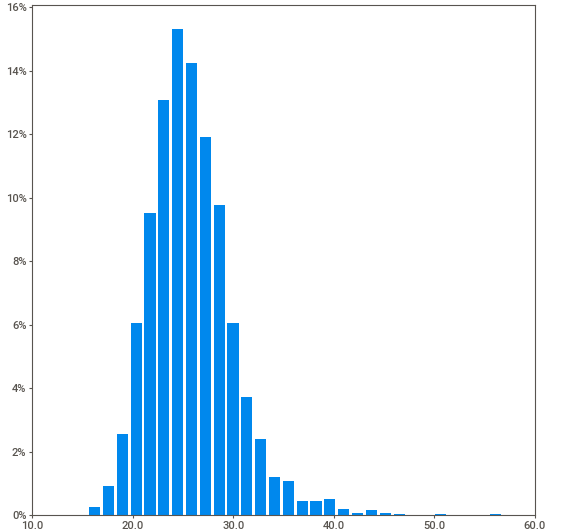
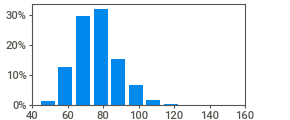
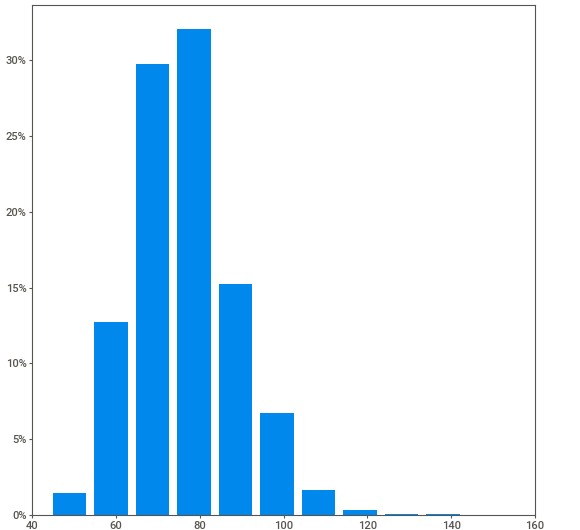
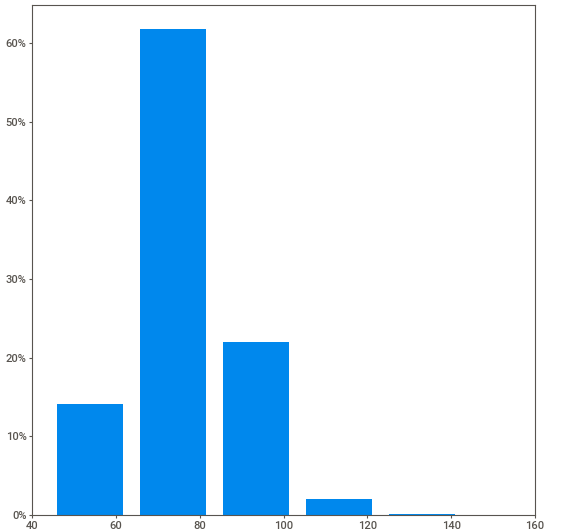
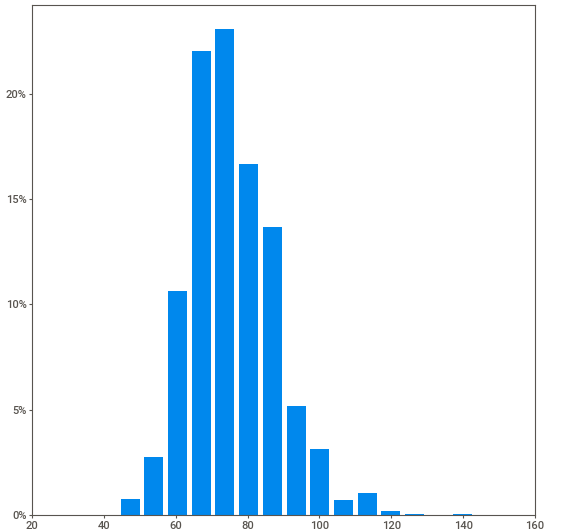
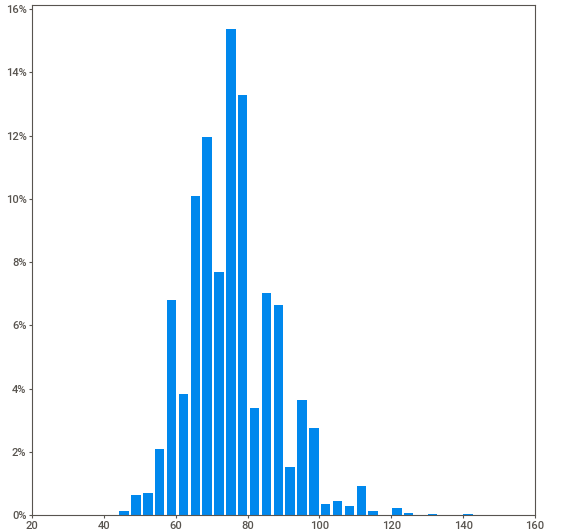
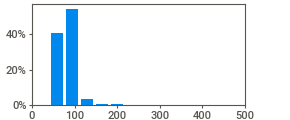
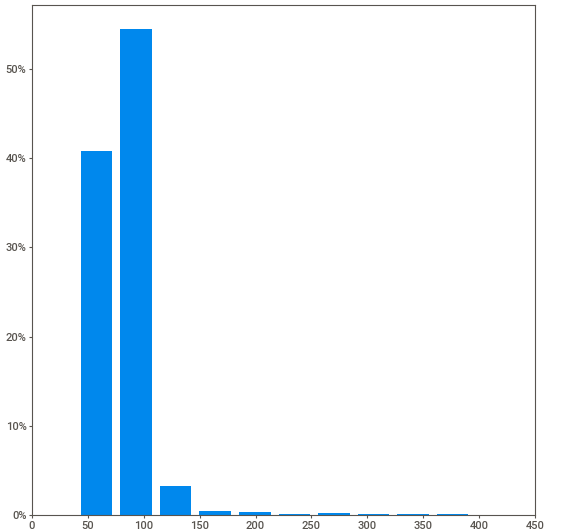
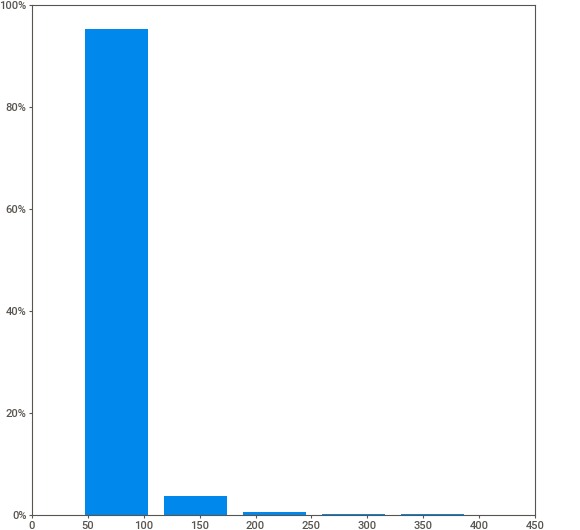
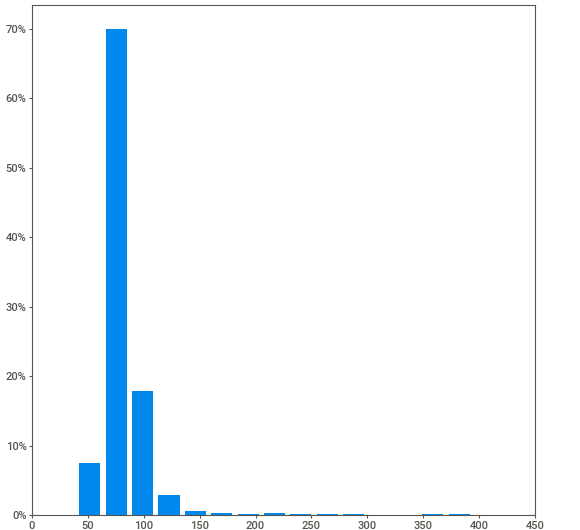
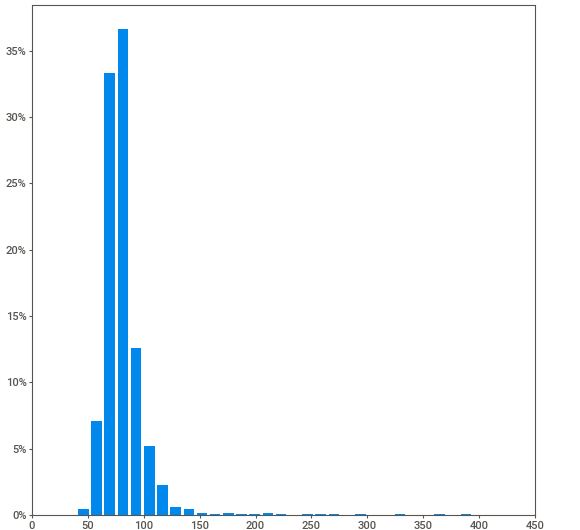
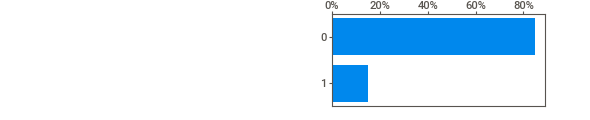
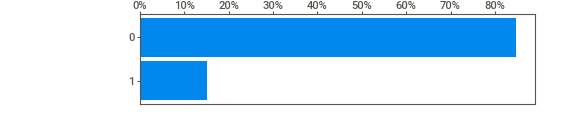
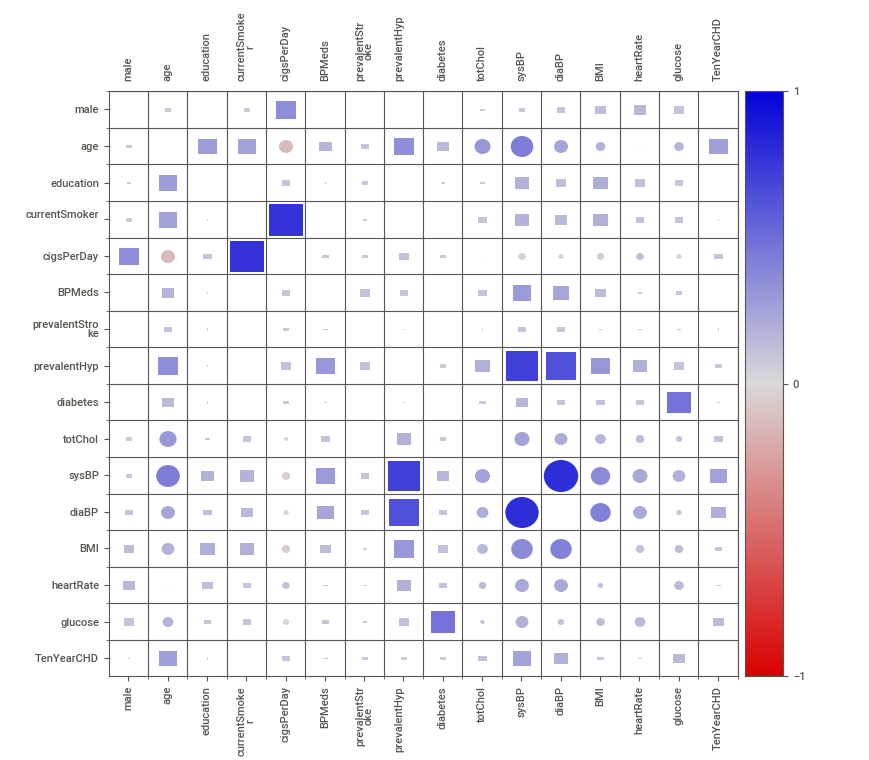
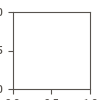

Report Report.show_html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [45]:
report = sv.analyze(df)
report.show_notebook('Report.show_notebook')
# Html link for the report (the notebook doesn't displayed well on colab environment)
report.show_html('Report.show_html')


In [46]:
# Shape of the dataset
print("Shape of the dataset:", df.shape)

# Column names
print("Columns in the dataset:", df.columns)

# Data types
print("Data types:\n", df.dtypes)


Shape of the dataset: (4238, 16)
Columns in the dataset: Index(['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')
Data types:
 male                 int64
age                  int64
education          float64
currentSmoker        int64
cigsPerDay         float64
BPMeds             float64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
dtype: object


In [47]:
# First few rows
print("First few rows:\n", df.head())



First few rows:
    male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4             0         0    285.0  130.0   84.0  23.10       85.0     85.0   

   TenYearCHD  
0           0  
1

## Handling missing values


In [48]:

print("Missing values:\n", df.isnull().sum())

Missing values:
 male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64


We can examine that we got null values in following features :
education (105) - 2.47%
cigsPerDay (29) - 0.68%
BPMeds (53) - 1.25%
totChol (50) - 1.17%
BMI (19) - 0.44%
heartRate (1) - 0.02%
glucose (388) - 9.15%


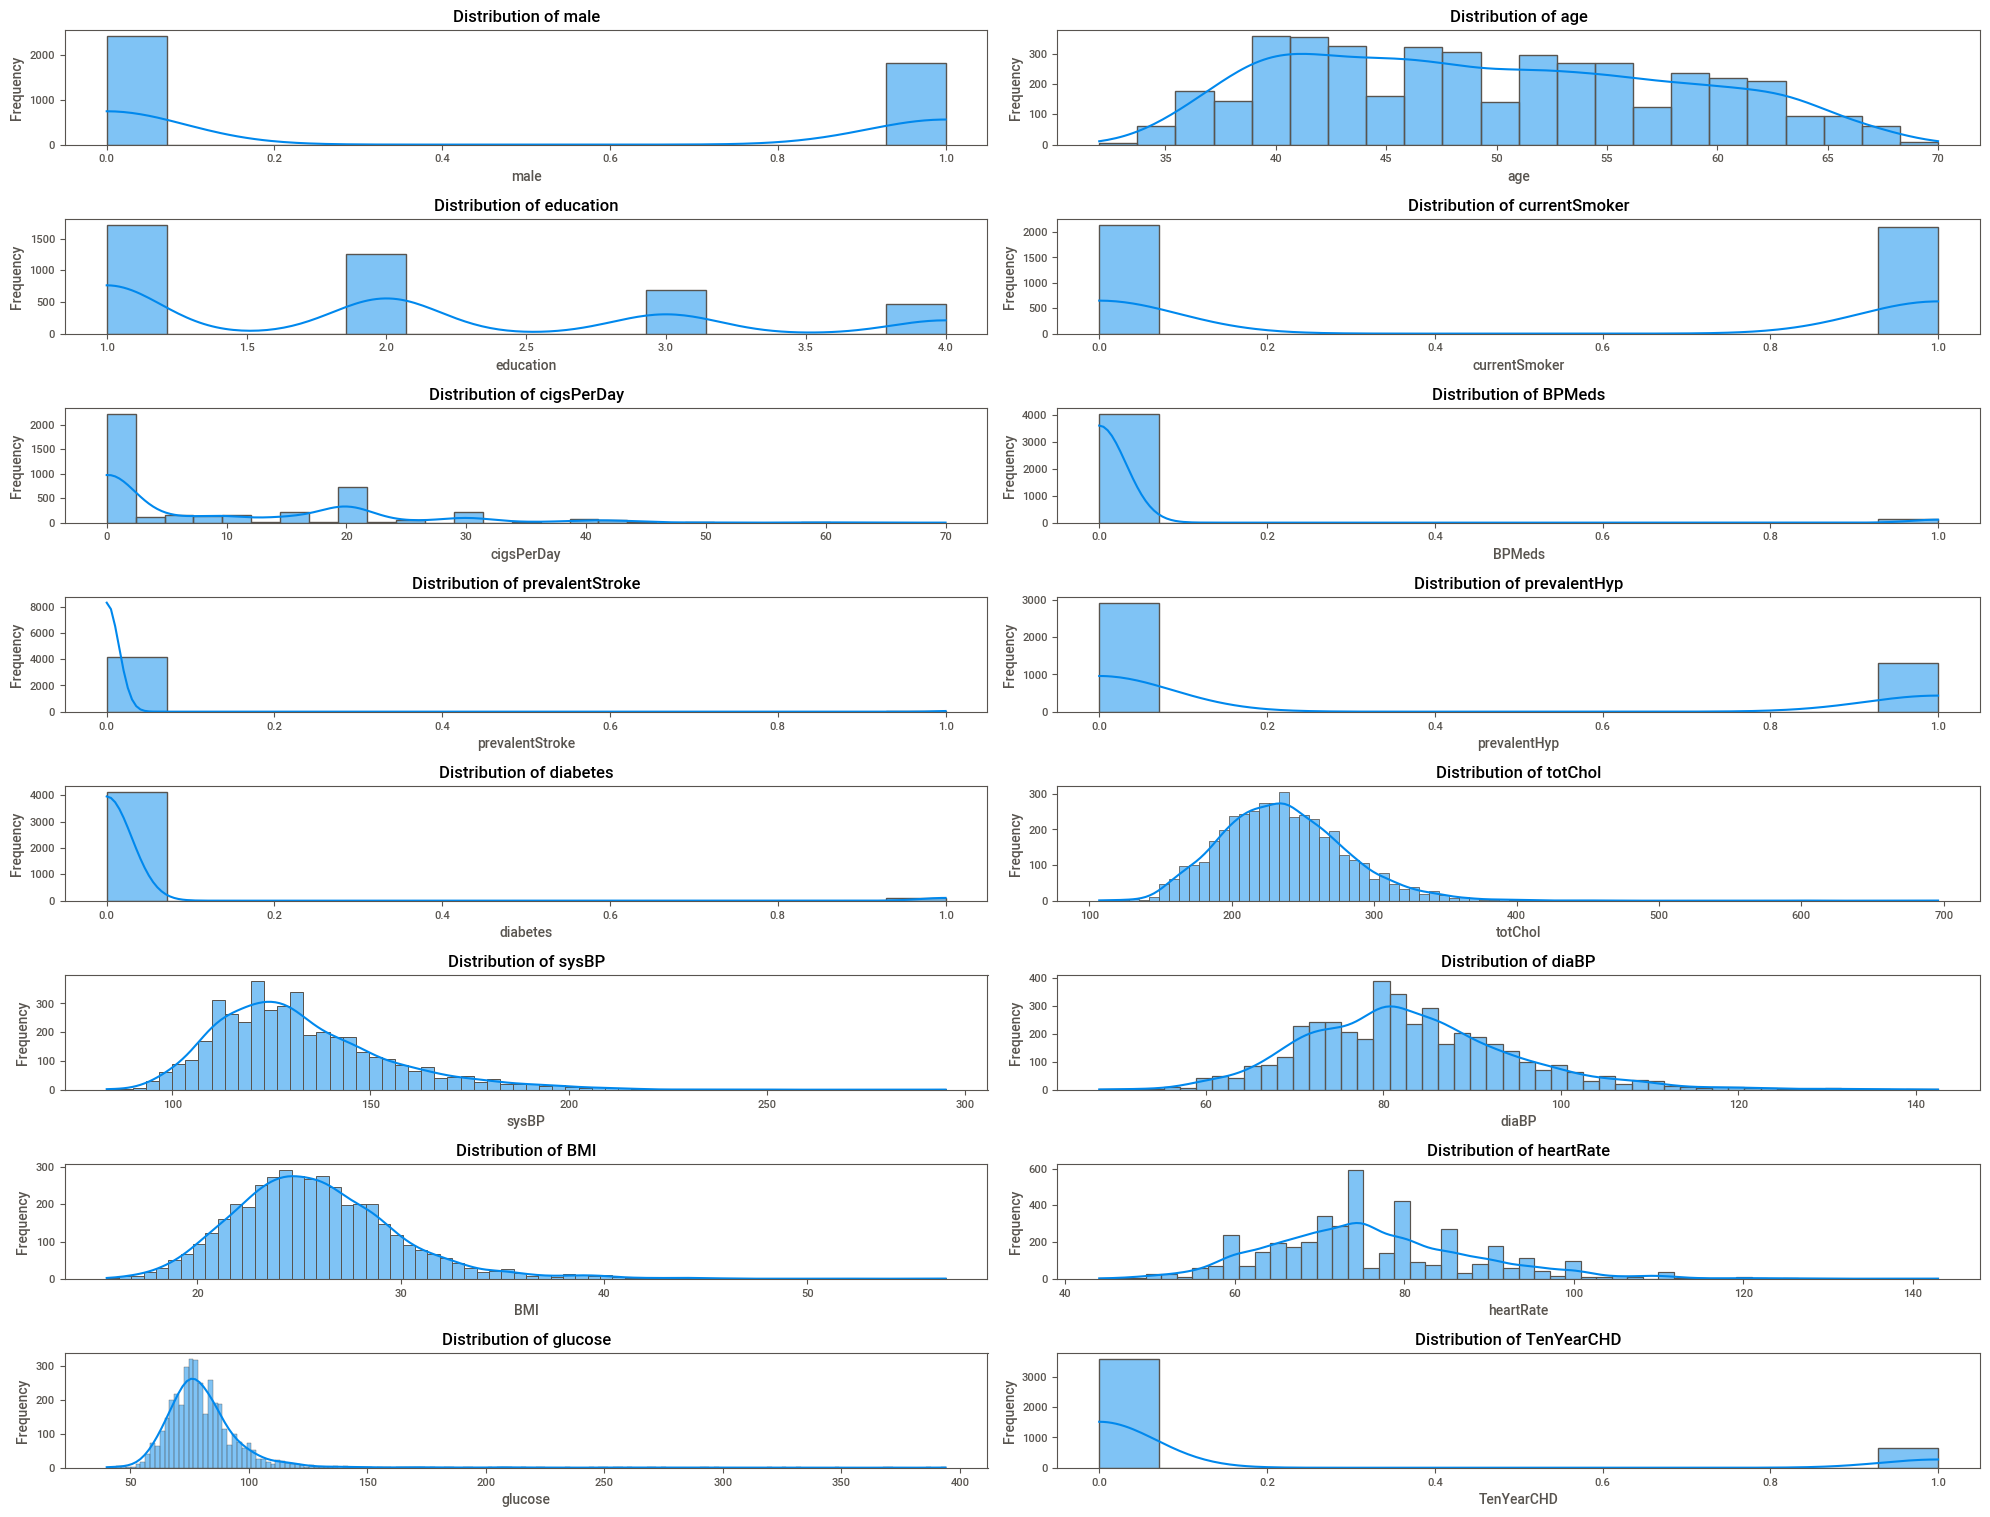

In [49]:
#Testing the distribution of data

numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(20, 30))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, i)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

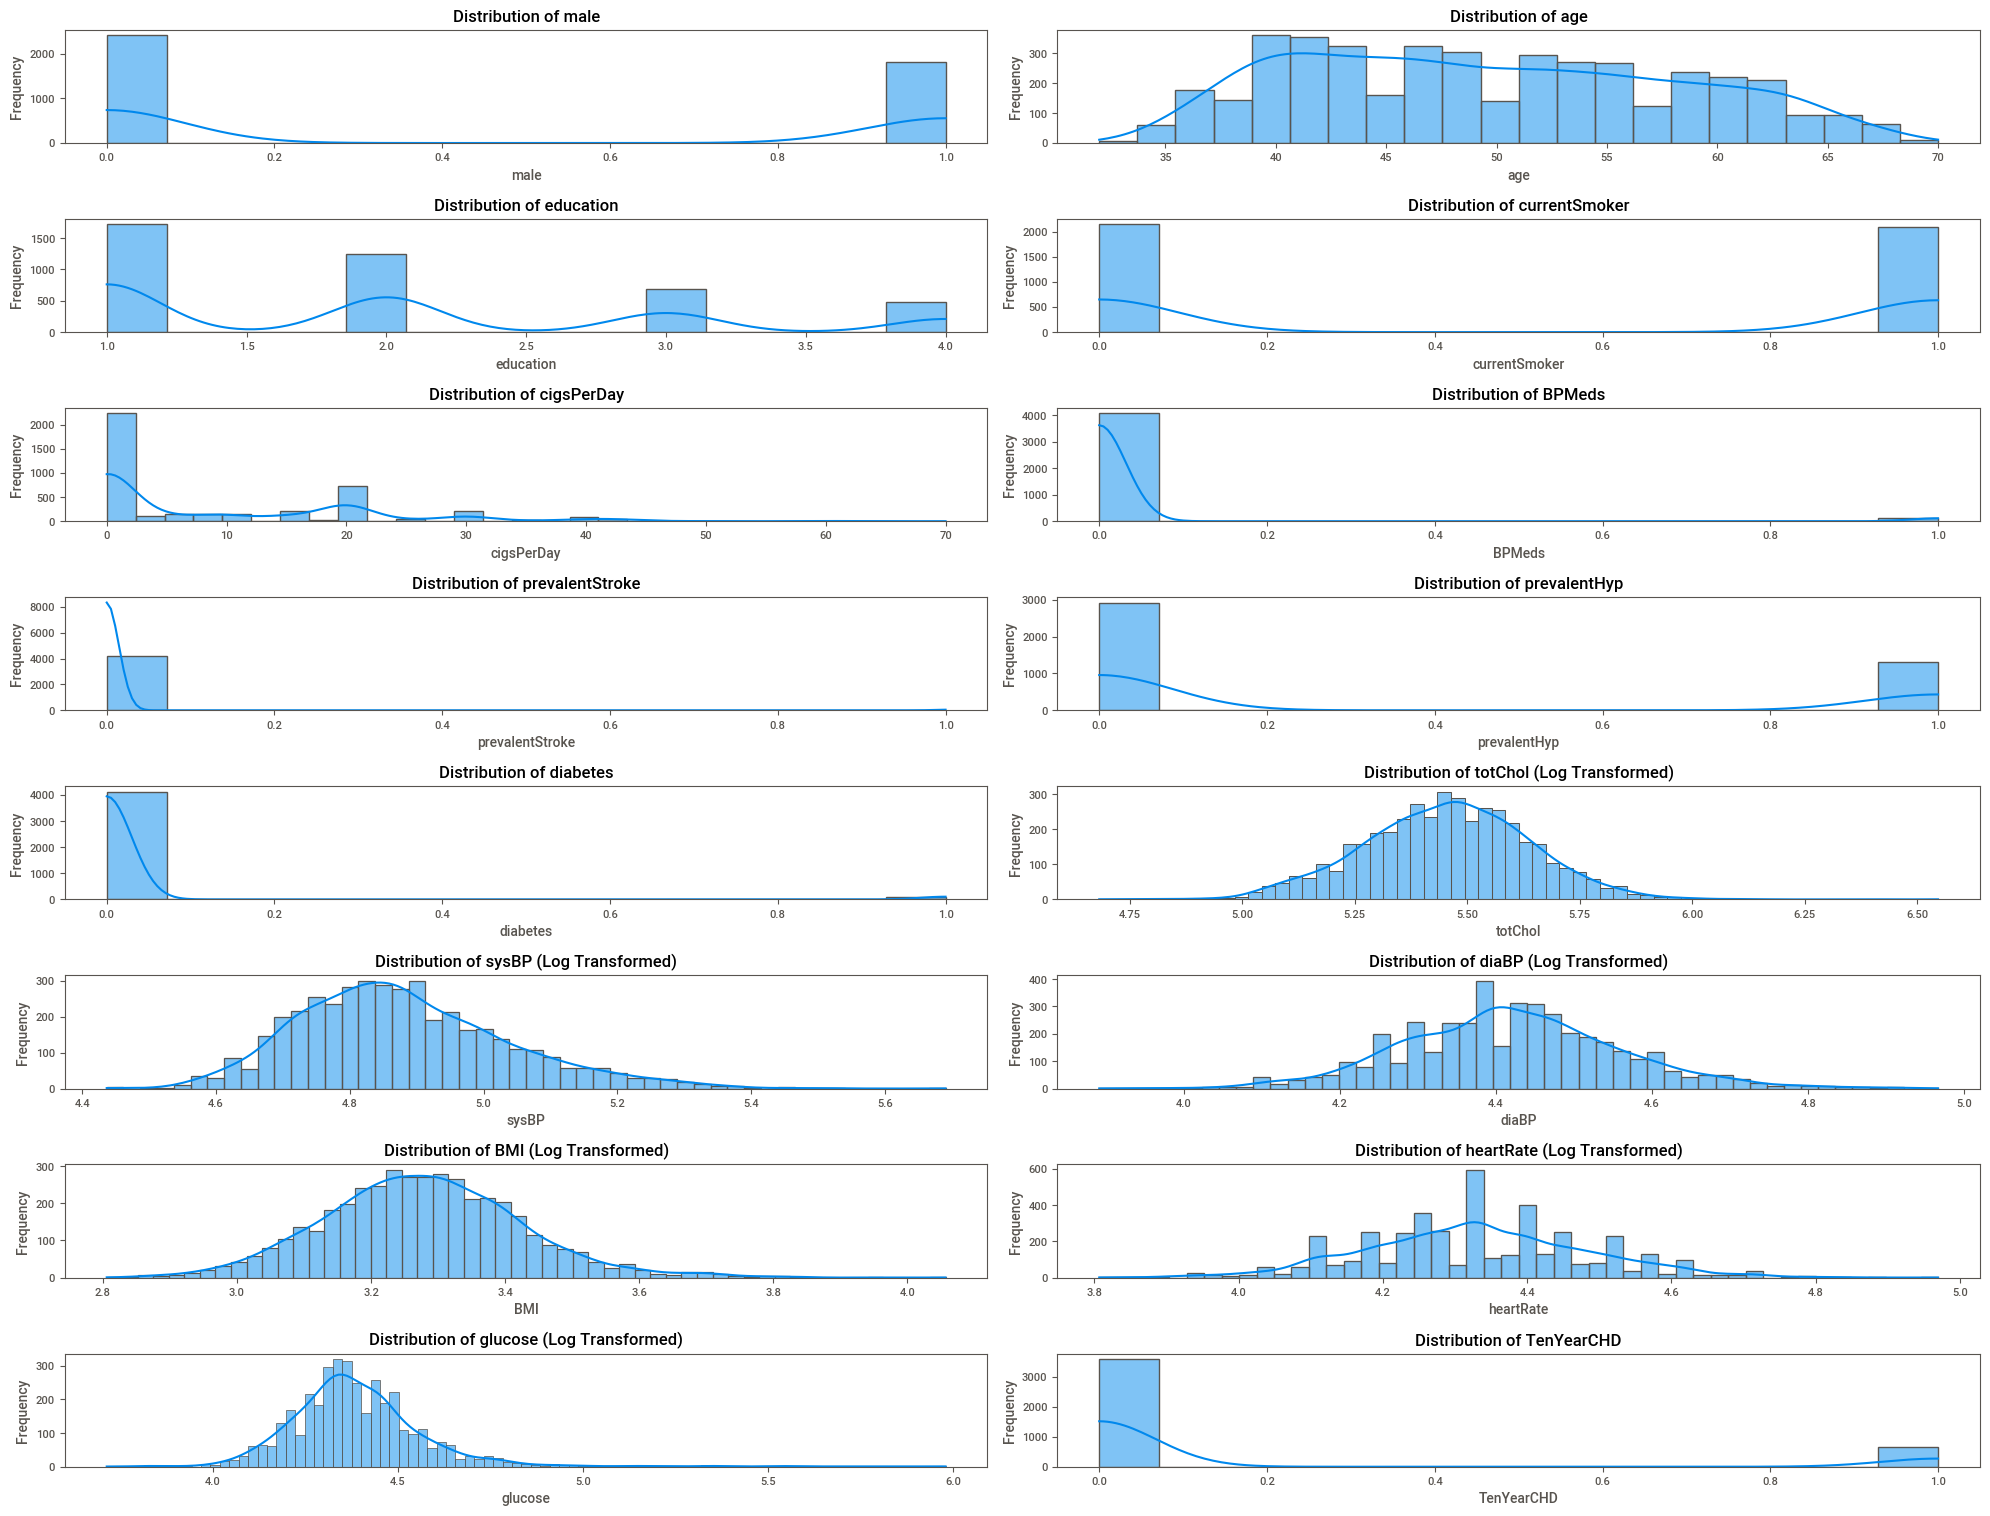

In [50]:
#Feature transformation- Performing a logarithm for tailed variables

columns_to_transform = ['totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

df_log_transformed = df.copy()
df_log_transformed[columns_to_transform] = df_log_transformed[columns_to_transform].apply(lambda x: np.log1p(x))

numerical_columns = df_log_transformed.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(20, 30))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, i)
    sns.histplot(df_log_transformed[column], kde=True)
    plt.title(f'Distribution of {column} (Log Transformed)' if column in columns_to_transform else f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

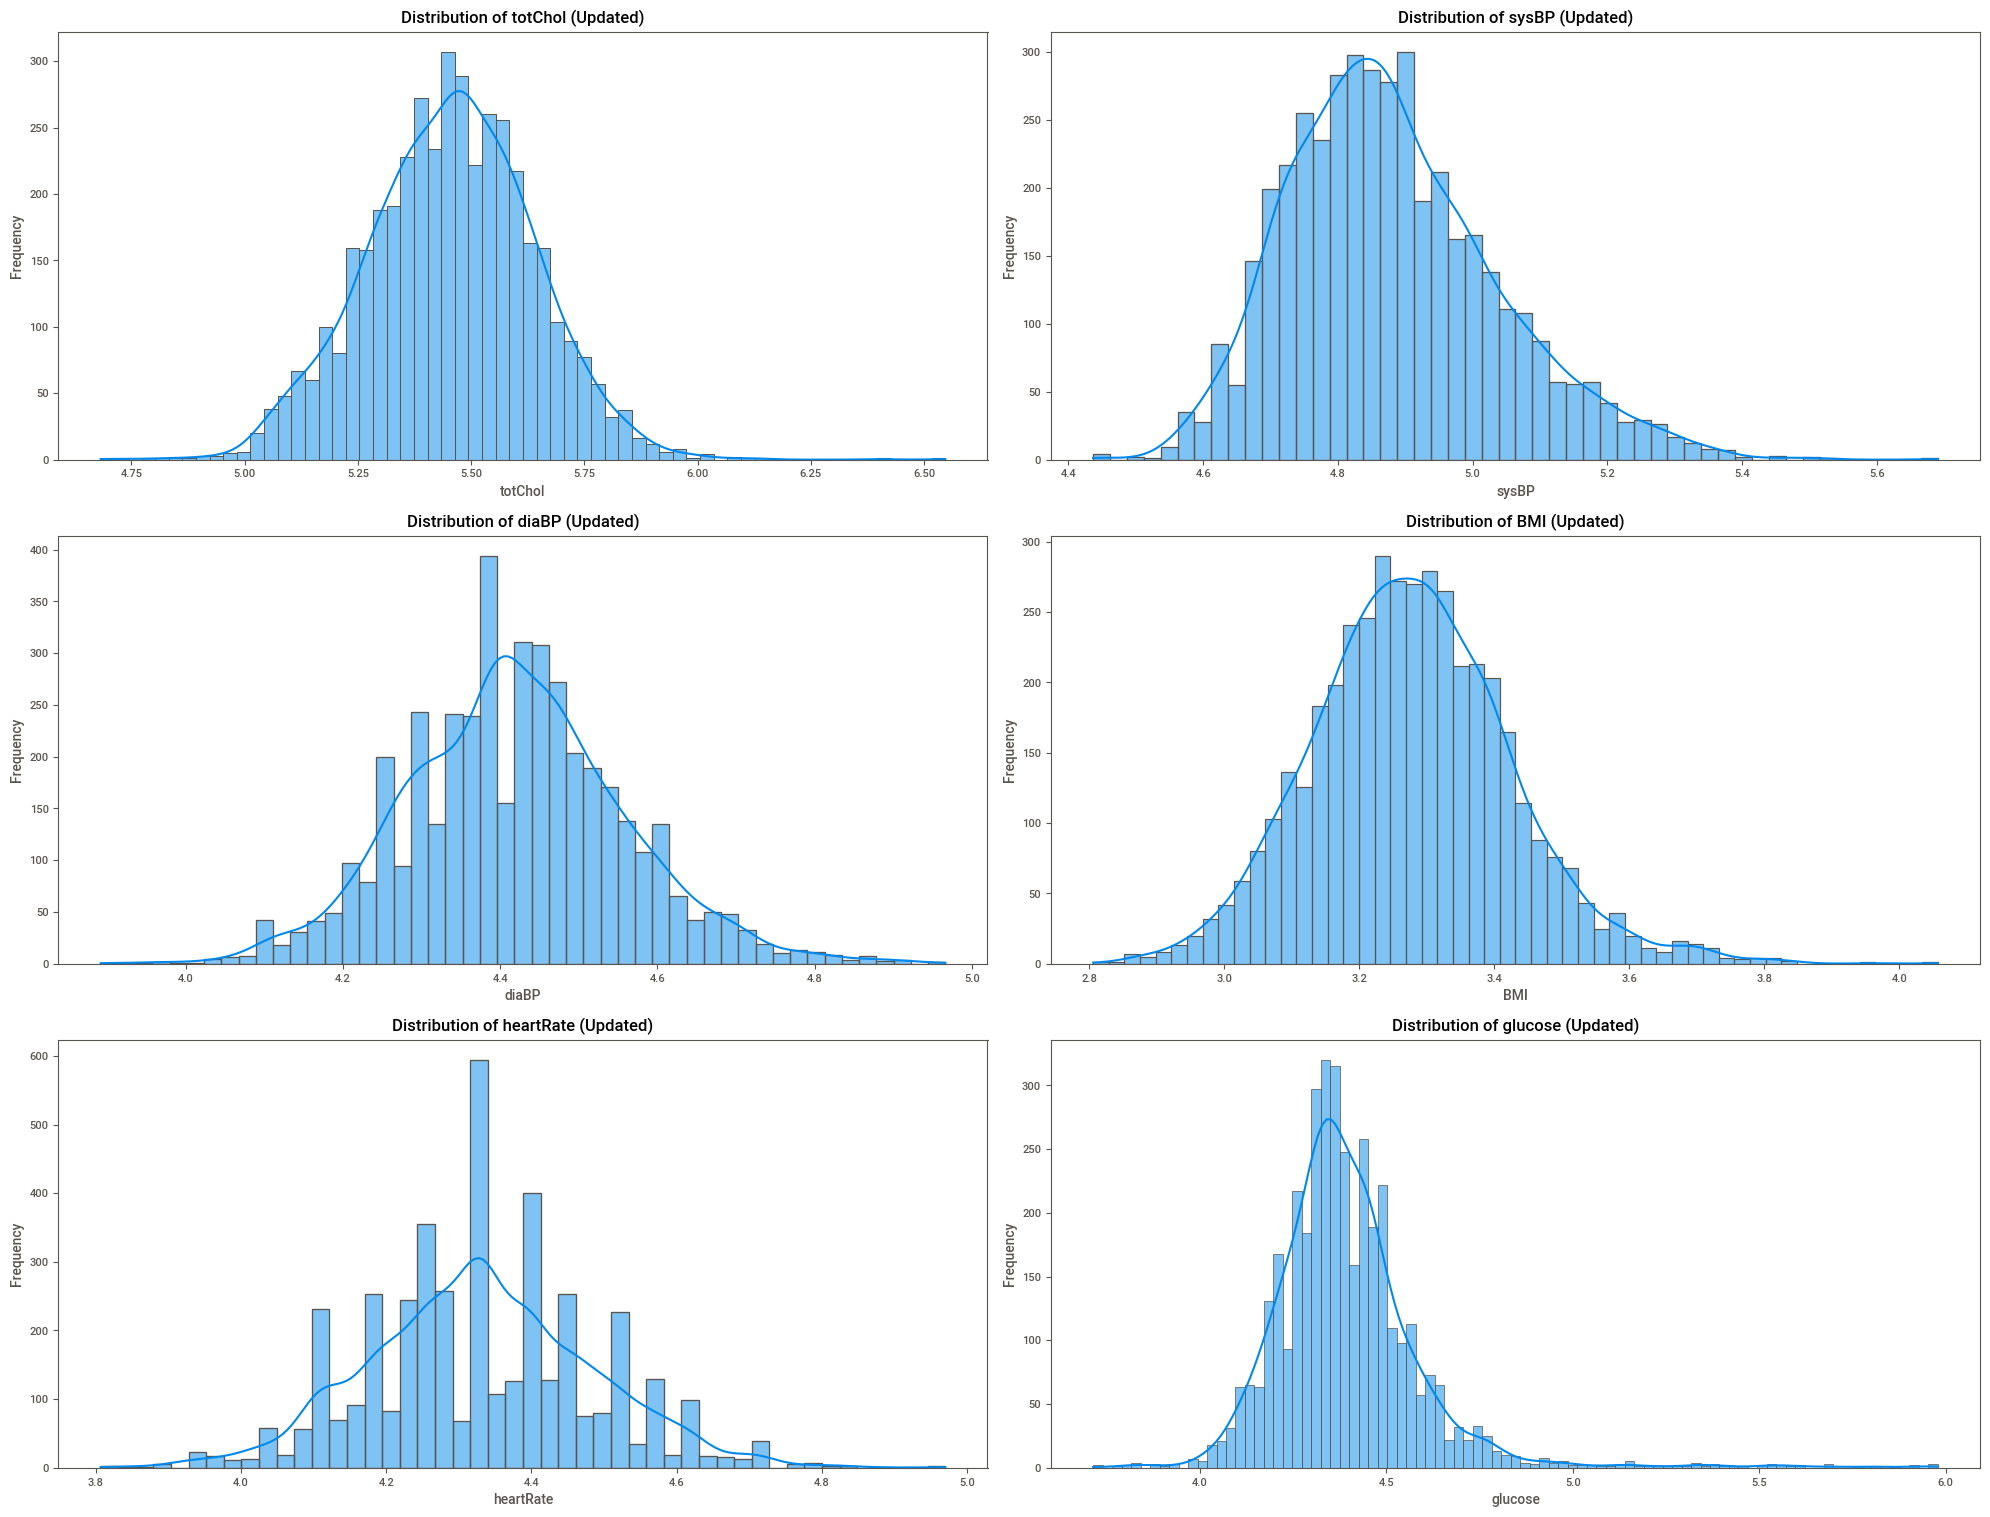

In [51]:
#Changing the original df where the logarithm improved the Distribution
for column in columns_to_transform:
    if df_log_transformed[column].skew() < df[column].skew():
        df[column] = df_log_transformed[column]
plt.figure(figsize=(20, 30))
for i, column in enumerate(columns_to_transform, 1):
    plt.subplot(len(columns_to_transform), 2, i)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column} (Updated)')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [52]:
#Filling the na valuse with median or mode
columns_to_fill_median = ['cigsPerDay','totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']


for column in columns_to_fill_median :
    median_value = df[column].median()
    df[column].fillna(median_value, inplace=True)


columns_to_fill_mode = ['education', 'BPMeds']
for column in columns_to_fill_mode:
    mode_value = df[column].mode()[0]
    df[column].fillna(mode_value, inplace=True)

#Confirm that all the missing values take cared
print("Missing values:\n", df.isnull().sum())

Missing values:
 male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64


##Handling of abnormal values


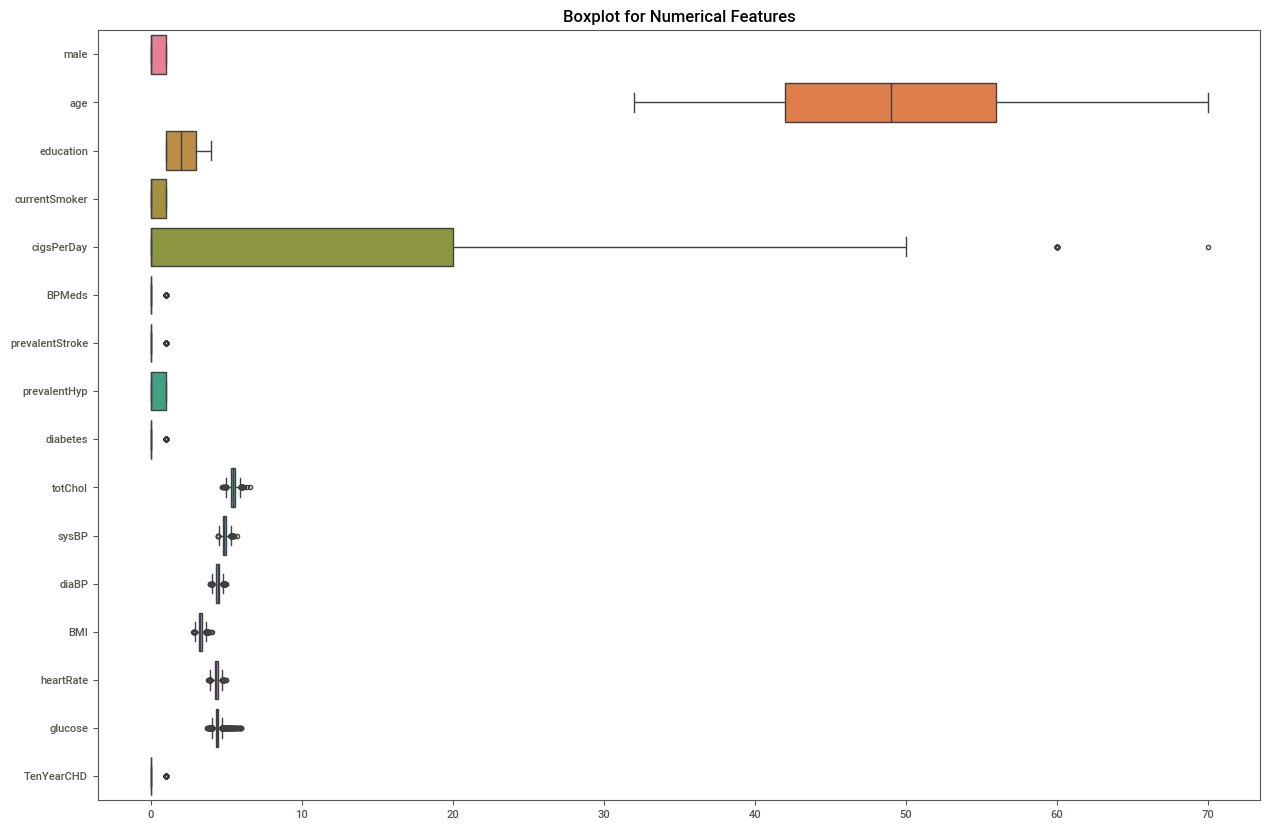

In [53]:

plt.figure(figsize=(15, 10))
sns.boxplot(data=df, orient='h')
plt.title('Boxplot for Numerical Features')
plt.show()

In [54]:
#Chacking for wrong (illogical) values
for column in df.columns:
    min_value = df[column].min()
    max_value = df[column].max()
    print(f'Column: {column}')
    print(f'  Min Value: {min_value}')
    print(f'  Max Value: {max_value}')
    print('-------------------------')


Column: male
  Min Value: 0
  Max Value: 1
-------------------------
Column: age
  Min Value: 32
  Max Value: 70
-------------------------
Column: education
  Min Value: 1.0
  Max Value: 4.0
-------------------------
Column: currentSmoker
  Min Value: 0
  Max Value: 1
-------------------------
Column: cigsPerDay
  Min Value: 0.0
  Max Value: 70.0
-------------------------
Column: BPMeds
  Min Value: 0.0
  Max Value: 1.0
-------------------------
Column: prevalentStroke
  Min Value: 0
  Max Value: 1
-------------------------
Column: prevalentHyp
  Min Value: 0
  Max Value: 1
-------------------------
Column: diabetes
  Min Value: 0
  Max Value: 1
-------------------------
Column: totChol
  Min Value: 4.68213122712422
  Max Value: 6.546785410760524
-------------------------
Column: sysBP
  Min Value: 4.436751534363128
  Max Value: 5.69035945432406
-------------------------
Column: diaBP
  Min Value: 3.8918202981106265
  Max Value: 4.966335035199676
-------------------------
Column: BMI
 

No data change is required

### **Traning The Model**

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
import sweetviz as sv
import itertools
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from imblearn.under_sampling import RandomUnderSampler


In [56]:
X = df.drop('TenYearCHD', axis=1)
y = df['TenYearCHD']


# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Build the model( model:1)


In [57]:

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_final.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train_final, y_train_final,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val))
y_val_pred = model.predict(X_val)
y_val_pred_classes = (y_val_pred > 0.5).astype(int)

# Confusion matrix on validation data
cm = confusion_matrix(y_val, y_val_pred_classes)
print('Confusion Matrix:')
print(cm)
class_report_1 = classification_report(y_val, y_val_pred_classes)
print('Classification Report:')
print(class_report_1)


Epoch 1/50
85/85 [==============================] - 1s 4ms/step - loss: 0.5559 - accuracy: 0.7765 - val_loss: 0.4177 - val_accuracy: 0.8510
Epoch 2/50
85/85 [==============================] - 0s 2ms/step - loss: 0.4779 - accuracy: 0.8414 - val_loss: 0.4038 - val_accuracy: 0.8510
Epoch 3/50
85/85 [==============================] - 0s 2ms/step - loss: 0.4457 - accuracy: 0.8392 - val_loss: 0.3991 - val_accuracy: 0.8510
Epoch 4/50
85/85 [==============================] - 0s 2ms/step - loss: 0.4452 - accuracy: 0.8378 - val_loss: 0.3966 - val_accuracy: 0.8451
Epoch 5/50
85/85 [==============================] - 0s 2ms/step - loss: 0.4312 - accuracy: 0.8470 - val_loss: 0.3941 - val_accuracy: 0.8451
Epoch 6/50
85/85 [==============================] - 0s 2ms/step - loss: 0.4255 - accuracy: 0.8448 - val_loss: 0.3943 - val_accuracy: 0.8437
Epoch 7/50
85/85 [==============================] - 0s 2ms/step - loss: 0.4150 - accuracy: 0.8462 - val_loss: 0.3923 - val_accuracy: 0.8422
Epoch 8/50
85/85 [==

### Define an enhanced model architecture(model:2)


In [58]:

enhanced_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_final.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the enhanced model
enhanced_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# Train the enhanced model
enhanced_history = enhanced_model.fit(X_train_final, y_train_final,
                                      epochs=50,
                                      batch_size=32,
                                      validation_data=(X_val, y_val))

# Evaluate the enhanced model
enhanced_loss, enhanced_accuracy = enhanced_model.evaluate(X_test, y_test)
print(f'Test Accuracy of Enhanced Model: {enhanced_accuracy}')

# Predict on validation data with the enhanced model
y_val_pred_enhanced = enhanced_model.predict(X_val)
y_val_pred_classes_enhanced = (y_val_pred_enhanced > 0.5).astype(int)

# Confusion matrix on validation data for the enhanced model
cm_enhanced = confusion_matrix(y_val, y_val_pred_classes_enhanced)
print('Confusion Matrix:')
print(cm_enhanced)

# Classification report for the enhanced model
class_report_2 = classification_report(y_val, y_val_pred_classes_enhanced)
print('Classification Report:')
print(class_report_2)


Epoch 1/50
85/85 [==============================] - 1s 5ms/step - loss: 0.5593 - accuracy: 0.7817 - val_loss: 0.4293 - val_accuracy: 0.8510
Epoch 2/50
85/85 [==============================] - 0s 3ms/step - loss: 0.4699 - accuracy: 0.8429 - val_loss: 0.4049 - val_accuracy: 0.8510
Epoch 3/50
85/85 [==============================] - 0s 3ms/step - loss: 0.4453 - accuracy: 0.8440 - val_loss: 0.4053 - val_accuracy: 0.8510
Epoch 4/50
85/85 [==============================] - 0s 3ms/step - loss: 0.4390 - accuracy: 0.8440 - val_loss: 0.3953 - val_accuracy: 0.8510
Epoch 5/50
85/85 [==============================] - 0s 3ms/step - loss: 0.4346 - accuracy: 0.8440 - val_loss: 0.3956 - val_accuracy: 0.8510
Epoch 6/50
85/85 [==============================] - 0s 3ms/step - loss: 0.4176 - accuracy: 0.8451 - val_loss: 0.3902 - val_accuracy: 0.8510
Epoch 7/50
85/85 [==============================] - 0s 3ms/step - loss: 0.4159 - accuracy: 0.8455 - val_loss: 0.3909 - val_accuracy: 0.8510
Epoch 8/50
85/85 [==

## Using weights to reduce the bias (model :3)


In [59]:

# Compute class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_final), y=y_train_final)
class_weights_dict = dict(enumerate(class_weights))

# Train the enhanced model with class weights
enhanced_history = enhanced_model.fit(X_train_final, y_train_final,
                                      epochs=50,
                                      batch_size=32,
                                      validation_data=(X_val, y_val),
                                      class_weight=class_weights_dict)
# Evaluate the enhanced model
enhanced_loss, enhanced_accuracy = enhanced_model.evaluate(X_test, y_test)
print(f'Test Accuracy of Enhanced Model:{enhanced_accuracy}')

# Predict on validation data with the enhanced model
y_val_pred_weights = enhanced_model.predict(X_val)
y_val_pred_classes_weights = (y_val_pred_enhanced > 0.5).astype(int)

# Confusion matrix on validation data for the enhanced model
cm_weights = confusion_matrix(y_val, y_val_pred_classes_weights)
print('Confusion Matrix:')
print(cm_weights)

# Classification report for the enhanced model
class_report_3 = classification_report(y_val,y_val_pred_classes_weights)
print('Classification Report:')
print(class_report_3)



Epoch 1/50
85/85 [==============================] - 1s 4ms/step - loss: 0.6653 - accuracy: 0.8027 - val_loss: 0.5784 - val_accuracy: 0.7330
Epoch 2/50
85/85 [==============================] - 0s 3ms/step - loss: 0.6134 - accuracy: 0.7625 - val_loss: 0.5725 - val_accuracy: 0.7212
Epoch 3/50
85/85 [==============================] - 0s 3ms/step - loss: 0.6038 - accuracy: 0.7596 - val_loss: 0.5808 - val_accuracy: 0.7242
Epoch 4/50
85/85 [==============================] - 0s 3ms/step - loss: 0.6089 - accuracy: 0.7437 - val_loss: 0.5948 - val_accuracy: 0.6962
Epoch 5/50
85/85 [==============================] - 0s 3ms/step - loss: 0.5911 - accuracy: 0.7400 - val_loss: 0.5870 - val_accuracy: 0.6947
Epoch 6/50
85/85 [==============================] - 0s 3ms/step - loss: 0.5968 - accuracy: 0.7360 - val_loss: 0.5896 - val_accuracy: 0.7021
Epoch 7/50
85/85 [==============================] - 0s 3ms/step - loss: 0.5962 - accuracy: 0.7445 - val_loss: 0.6128 - val_accuracy: 0.6932
Epoch 8/50
85/85 [==

## Using SMOTE to reduce the bias (model :4)


In [60]:

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_final, y_train_final)

# Define an enhanced model architecture
enhanced_model_smote = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_smote.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the enhanced model with a lower learning rate
enhanced_model_smote.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

# Train the enhanced model with SMOTE data
enhanced_history_smote = enhanced_model_smote.fit(X_train_smote, y_train_smote,
                                                  epochs=100,
                                                  batch_size=16,
                                                  validation_data=(X_val, y_val))

# Evaluate the enhanced model with SMOTE
enhanced_loss_smote, enhanced_accuracy_smote = enhanced_model_smote.evaluate(X_test, y_test)
print(f'Test Accuracy of Enhanced Model with SMOTE: {enhanced_accuracy_smote}')

# Predict on validation data with the enhanced model using SMOTE
y_val_pred_enhanced_smote = enhanced_model_smote.predict(X_val)
y_val_pred_classes_enhanced_smote = (y_val_pred_enhanced_smote > 0.5).astype(int)

# Confusion matrix on validation data for the enhanced model using SMOTE
cm_enhanced_smote = confusion_matrix(y_val, y_val_pred_classes_enhanced_smote)
print('Confusion Matrix:')
print(cm_enhanced_smote)

# Classification report for the enhanced model using SMOTE
class_report_4 = classification_report(y_val, y_val_pred_classes_enhanced_smote)
print('Classification Report:')
print(class_report_4)


Epoch 1/100
287/287 [==============================] - 2s 3ms/step - loss: 0.7118 - accuracy: 0.5257 - val_loss: 0.6539 - val_accuracy: 0.7183
Epoch 2/100
287/287 [==============================] - 1s 2ms/step - loss: 0.6804 - accuracy: 0.5706 - val_loss: 0.6458 - val_accuracy: 0.6770
Epoch 3/100
287/287 [==============================] - 1s 2ms/step - loss: 0.6633 - accuracy: 0.6042 - val_loss: 0.6320 - val_accuracy: 0.6814
Epoch 4/100
287/287 [==============================] - 1s 2ms/step - loss: 0.6500 - accuracy: 0.6182 - val_loss: 0.6266 - val_accuracy: 0.6814
Epoch 5/100
287/287 [==============================] - 1s 2ms/step - loss: 0.6293 - accuracy: 0.6409 - val_loss: 0.6124 - val_accuracy: 0.6829
Epoch 6/100
287/287 [==============================] - 1s 2ms/step - loss: 0.6299 - accuracy: 0.6553 - val_loss: 0.6178 - val_accuracy: 0.6740
Epoch 7/100
287/287 [==============================] - 1s 3ms/step - loss: 0.6218 - accuracy: 0.6568 - val_loss: 0.6088 - val_accuracy: 0.6740

In [61]:
class RandomModel:
    def fit(self, X, y):
        self.classes_, self.class_counts_ = np.unique(y, return_counts=True)
        self.probabilities_ = self.class_counts_ / self.class_counts_.sum()

    def predict(self, X):
        return np.random.choice(self.classes_, size=len(X), p=self.probabilities_)

# Initialize and fit the random model
random_model = RandomModel()
random_model.fit(X_train_final, y_train_final)

# Predict on validation data
y_val_pred_random = random_model.predict(X_val)

# Confusion matrix on validation data for Random Model
cm_random = confusion_matrix(y_val, y_val_pred_random)
print('Confusion Matrix:')
print(cm_random)

# Classification report for Random Model
class_report_random = classification_report(y_val, y_val_pred_random)
print('Classification Report:')
print(class_report_random)

Confusion Matrix:
[[491  86]
 [ 82  19]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       577
           1       0.18      0.19      0.18       101

    accuracy                           0.75       678
   macro avg       0.52      0.52      0.52       678
weighted avg       0.76      0.75      0.75       678



## Using cross-validation (model:5)


In [62]:

# Define the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Evaluate the model using cross-validation
scores = cross_val_score(gb_model, X_train_final, y_train_final, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {scores}')
print(f'Mean Cross-Validation Accuracy: {scores.mean()}')

# Fit the model on the training data
gb_model.fit(X_train_final, y_train_final)

# Predict on validation data
y_val_pred_gb = gb_model.predict(X_val)

# Confusion matrix on validation data for Gradient Boosting
cm_gb = confusion_matrix(y_val, y_val_pred_gb)
print('Confusion Matrix:')
print(cm_gb)

# Classification report for Gradient Boosting
class_report_5 = classification_report(y_val, y_val_pred_gb)
print('Classification Report:')
print(class_report_5)


Cross-Validation Accuracy Scores: [0.83609576 0.84162063 0.83579336 0.84132841 0.8597786 ]
Mean Cross-Validation Accuracy: 0.8429233518854525
Confusion Matrix:
[[561  16]
 [ 90  11]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       577
           1       0.41      0.11      0.17       101

    accuracy                           0.84       678
   macro avg       0.63      0.54      0.54       678
weighted avg       0.79      0.84      0.80       678



## Using SMOTE and GridSearch to search for the best model (model :6)


In [63]:

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_final, y_train_final)

# Define the model
gb_model = GradientBoostingClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Perform grid search
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_smote, y_train_smote)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Evaluate the best model
best_model = grid_search.best_estimator_

# Predict on validation data
y_val_pred_best = best_model.predict(X_val)

# Confusion matrix on validation data for the best model
cm_best = confusion_matrix(y_val, y_val_pred_best)
print('Confusion Matrix:')
print(cm_best)

# Classification report for the best model
class_report_6 = classification_report(y_val, y_val_pred_best)
print('Classification Report:')
print(class_report_6)


Best parameters found:  {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}
Confusion Matrix:
[[545  32]
 [ 86  15]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       577
           1       0.32      0.15      0.20       101

    accuracy                           0.83       678
   macro avg       0.59      0.55      0.55       678
weighted avg       0.78      0.83      0.80       678



## Apply undersampling to the training data (model: 7)


In [64]:

undersample = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_train_under, y_train_under = undersample.fit_resample(X_train_final, y_train_final)

# Define an enhanced model architecture
enhanced_model_under = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_under.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the enhanced model with a lower learning rate
enhanced_model_under.compile(optimizer=Adam(learning_rate=0.0001),
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

# Train the enhanced model with undersampled data
enhanced_history_under = enhanced_model_under.fit(X_train_under, y_train_under,
                                                  epochs=100,
                                                  batch_size=16,
                                                  validation_data=(X_val, y_val))

# Evaluate the enhanced model with undersampled data
enhanced_loss_under, enhanced_accuracy_under = enhanced_model_under.evaluate(X_test, y_test)
print(f'Test Accuracy of Enhanced Model with Undersampling: {enhanced_accuracy_under}')

# Predict on validation data with the enhanced model using undersampling
y_val_pred_enhanced_under = enhanced_model_under.predict(X_val)
y_val_pred_classes_enhanced_under = (y_val_pred_enhanced_under > 0.5).astype(int)

# Confusion matrix on validation data for the enhanced model using undersampling
cm_enhanced_under = confusion_matrix(y_val, y_val_pred_classes_enhanced_under)
print('Confusion Matrix:')
print(cm_enhanced_under)

# Classification report for the enhanced model using undersampling
class_report_7 = classification_report(y_val, y_val_pred_classes_enhanced_under)
print('Classification Report:')
print(class_report_7)


Epoch 1/100
53/53 [==============================] - 2s 7ms/step - loss: 0.7428 - accuracy: 0.4940 - val_loss: 0.7167 - val_accuracy: 0.3584
Epoch 2/100
53/53 [==============================] - 0s 4ms/step - loss: 0.7071 - accuracy: 0.5119 - val_loss: 0.7152 - val_accuracy: 0.3938
Epoch 3/100
53/53 [==============================] - 0s 4ms/step - loss: 0.7135 - accuracy: 0.5143 - val_loss: 0.7149 - val_accuracy: 0.4425
Epoch 4/100
53/53 [==============================] - 0s 4ms/step - loss: 0.6992 - accuracy: 0.5263 - val_loss: 0.7114 - val_accuracy: 0.4912
Epoch 5/100
53/53 [==============================] - 0s 4ms/step - loss: 0.7064 - accuracy: 0.5191 - val_loss: 0.7081 - val_accuracy: 0.5354
Epoch 6/100
53/53 [==============================] - 0s 4ms/step - loss: 0.6854 - accuracy: 0.5477 - val_loss: 0.6986 - val_accuracy: 0.6077
Epoch 7/100
53/53 [==============================] - 0s 4ms/step - loss: 0.6825 - accuracy: 0.5525 - val_loss: 0.6966 - val_accuracy: 0.6106
Epoch 8/100
5

## Apply undersampling with enhanced architecture (model: 8)


In [65]:

# Apply undersampling to the training data
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_train_under, y_train_under = undersample.fit_resample(X_train_final, y_train_final)

# Define the base models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Define the Stacking Classifier
stacking_model = StackingClassifier(
    estimators=[('rf', rf_model), ('gb', gb_model)],
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42)
)

# Train the Stacking model
stacking_model.fit(X_train_under, y_train_under)

# Predict on validation data
y_val_pred_stacking = stacking_model.predict(X_val)

# Confusion matrix on validation data for the Stacking model
cm_stacking = confusion_matrix(y_val, y_val_pred_stacking)
print('Confusion Matrix:')
print(cm_stacking)

# Classification report for the Stacking model
class_report_8 = classification_report(y_val, y_val_pred_stacking)
print('Classification Report:')
print(class_report_8)


Confusion Matrix:
[[325 252]
 [ 39  62]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.56      0.69       577
           1       0.20      0.61      0.30       101

    accuracy                           0.57       678
   macro avg       0.55      0.59      0.49       678
weighted avg       0.79      0.57      0.63       678




#visualization of all the confusion matrixs

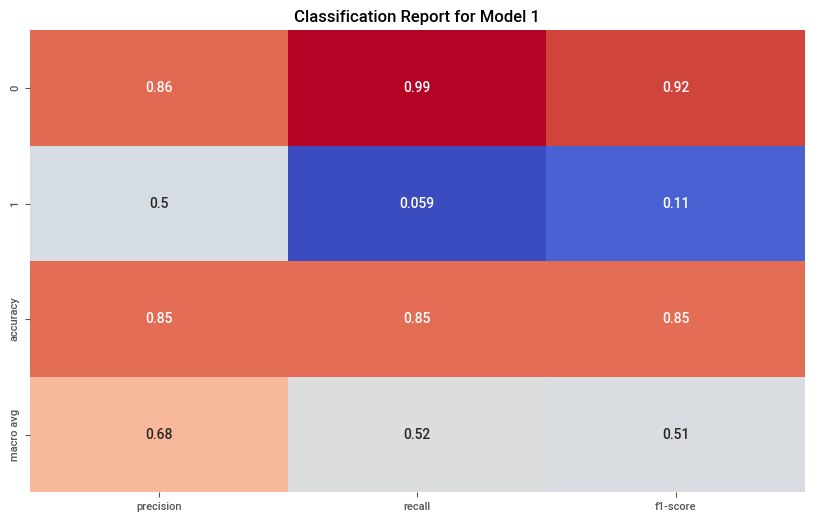

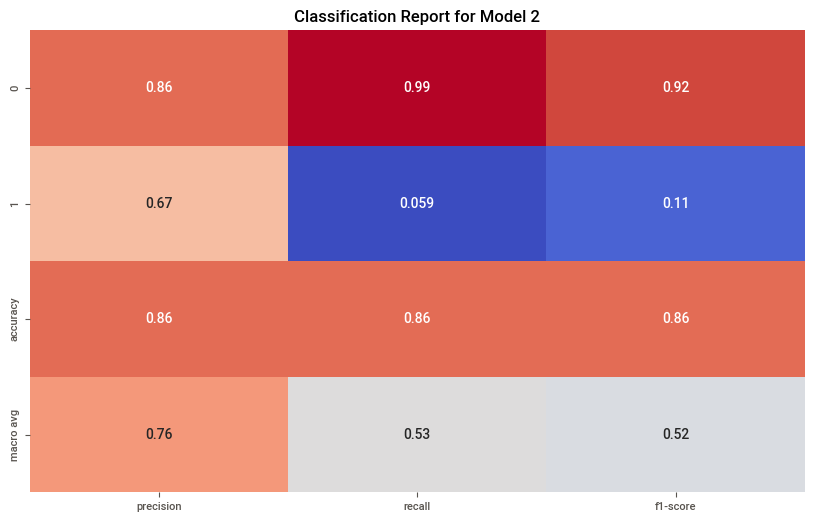

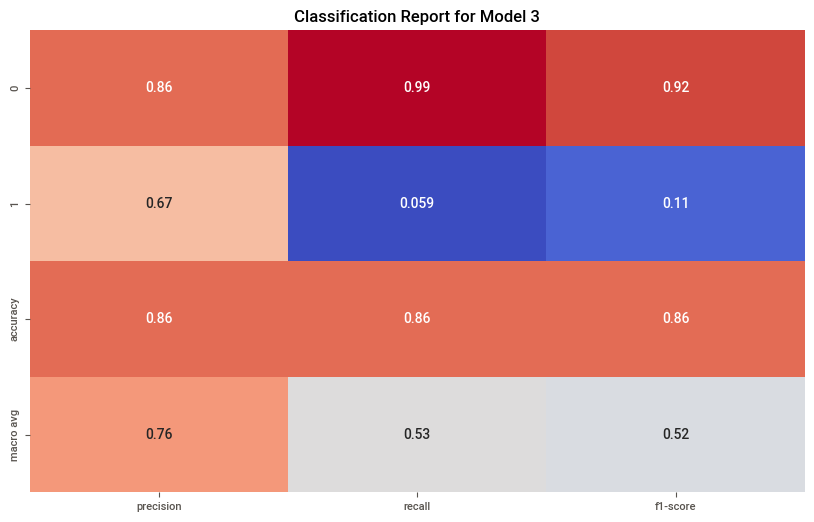

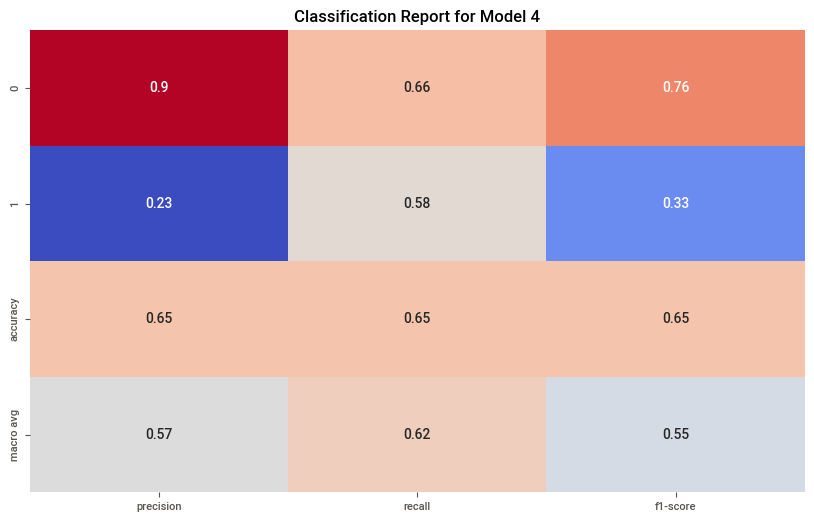

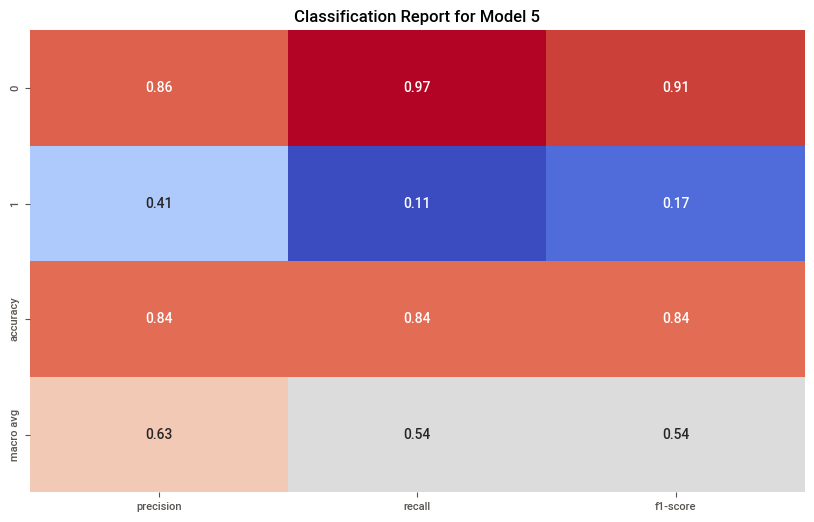

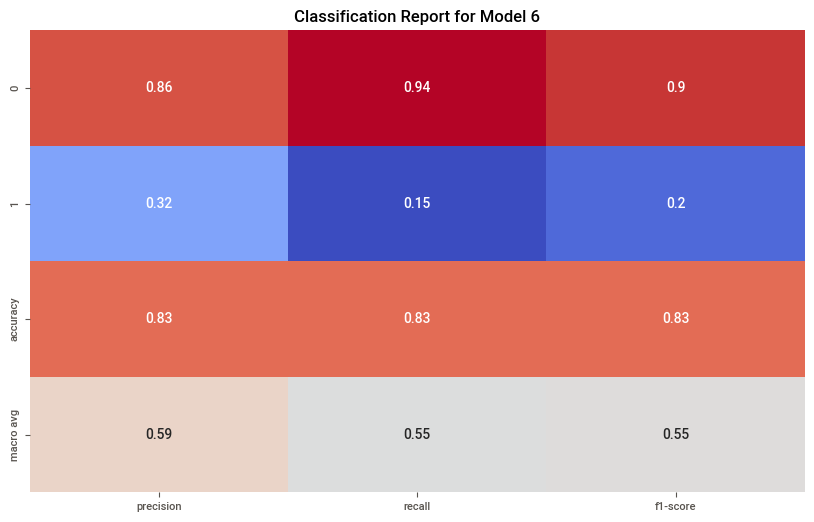

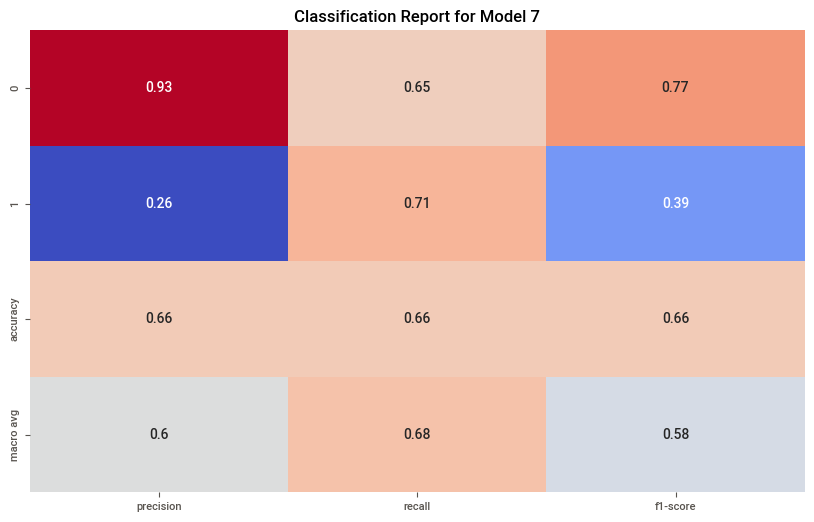

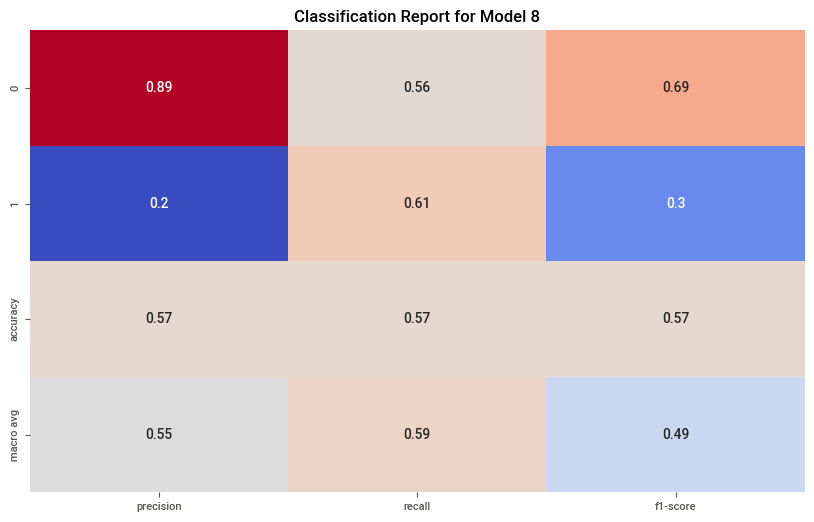

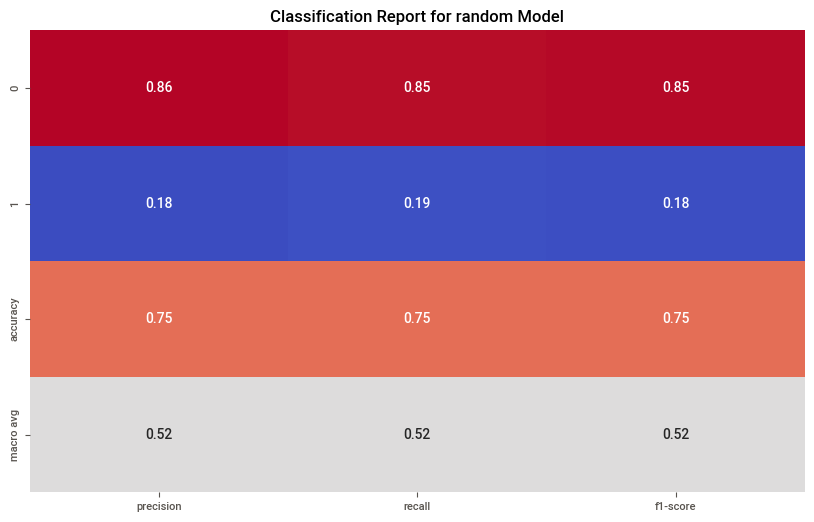

In [66]:

# Function to calculate metrics and return them in a dataframe

def get_classification_report_df(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
    return df

#Calculate metrics for each mode

report_model1 = get_classification_report_df(y_val,y_val_pred_classes)
report_model2 = get_classification_report_df(y_val, y_val_pred_classes_enhanced)
report_model3 = get_classification_report_df(y_val, y_val_pred_classes_weights)
report_model4 = get_classification_report_df(y_val,y_val_pred_classes_enhanced_smote[:len(y_val)])
report_model5 = get_classification_report_df(y_val, y_val_pred_gb)
report_model6 = get_classification_report_df(y_val, y_val_pred_best)
report_model7 = get_classification_report_df(y_val,y_val_pred_classes_enhanced_under)
report_model8 = get_classification_report_df(y_val,y_val_pred_stacking)
report_model_random=get_classification_report_df(y_val, y_val_pred_random)

#Function to create a heatmap for each model
def plot_classification_report_heatmap(report_df, title):
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='coolwarm', cbar=False)
    plt.title(title)
    plt.show()

#Create heatmaps for all models

plot_classification_report_heatmap(report_model1, 'Classification Report for Model 1')
plot_classification_report_heatmap(report_model2, 'Classification Report for Model 2')
plot_classification_report_heatmap(report_model3, 'Classification Report for Model 3')
plot_classification_report_heatmap(report_model4, 'Classification Report for Model 4')
plot_classification_report_heatmap(report_model5, 'Classification Report for Model 5')
plot_classification_report_heatmap(report_model6, 'Classification Report for Model 6')
plot_classification_report_heatmap(report_model7, 'Classification Report for Model 7')
plot_classification_report_heatmap(report_model8, 'Classification Report for Model 8')
plot_classification_report_heatmap(report_model_random, 'Classification Report for random Model')

#visualization of classes results


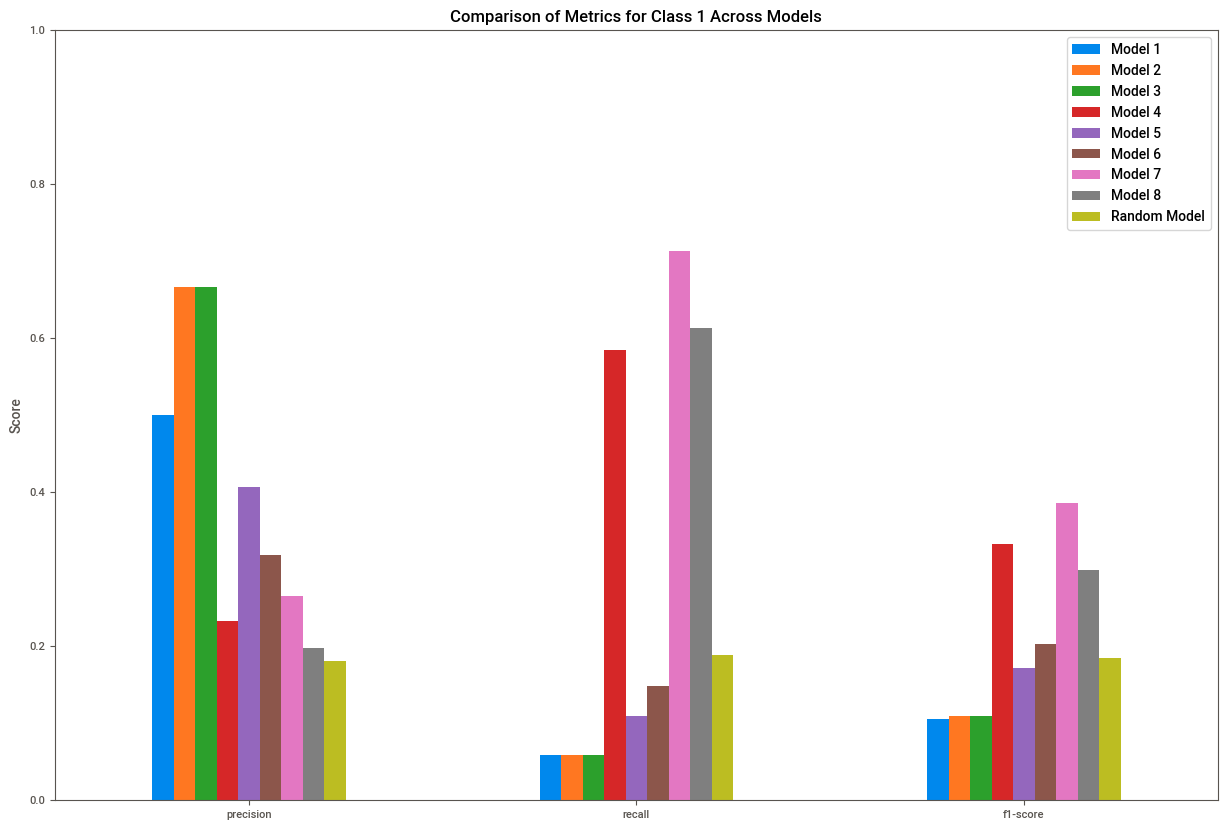

In [67]:

# Merging all the dataframes into one dataframe

reports = {
    "Model 1": report_model1,
    "Model 2": report_model2,
    "Model 3": report_model3,
    "Model 4": report_model4,
    "Model 5": report_model5,
    "Model 6": report_model6,
    "Model 7": report_model7,
    "Model 8": report_model8,
    "Random Model":report_model_random

}

#Selecting metrics to display for class 1
metrics = ['precision', 'recall', 'f1-score']

#Creating a dataframe for each model with the selected metrics for class 1
all_reports_class1 = {model: reports[model].loc['1', metrics].transpose() for model in reports}

#Creating a bar chart to compare metrics for class 1 across all models

fig, ax = plt.subplots(figsize=(15, 10))

df_all_reports_class1 = pd.DataFrame(all_reports_class1)
df_all_reports_class1.plot(kind='bar', ax=ax)
ax.set_title('Comparison of Metrics for Class 1 Across Models')
ax.set_ylabel('Score')
ax.set_ylim(0, 1)
plt.xticks(rotation=0)
plt.show()



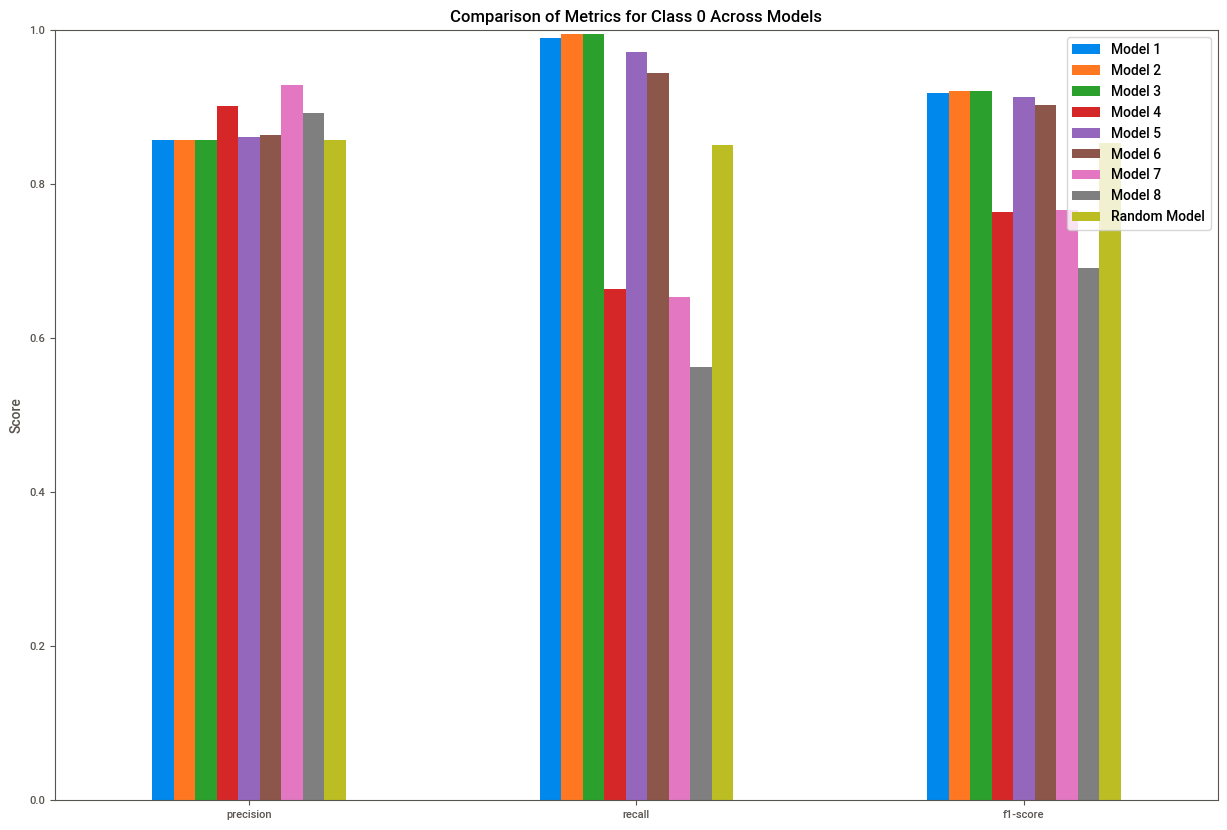

In [68]:

#Selecting metrics to display for class 0

metrics = ['precision', 'recall', 'f1-score']

# Creating a dataframe for each model with the selected metrics for class 0

all_reports = {model: reports[model].loc['0', metrics].transpose() for model in reports}

#Creating a bar chart to compare metrics for class 0 across all models
fig, ax = plt.subplots(figsize=(15, 10))

df_all_reports = pd.DataFrame(all_reports)
df_all_reports.plot(kind='bar', ax=ax)
ax.set_title('Comparison of Metrics for Class 0 Across Models')
ax.set_ylabel('Score')
ax.set_ylim(0, 1)
plt.xticks(rotation=0)
plt.show()


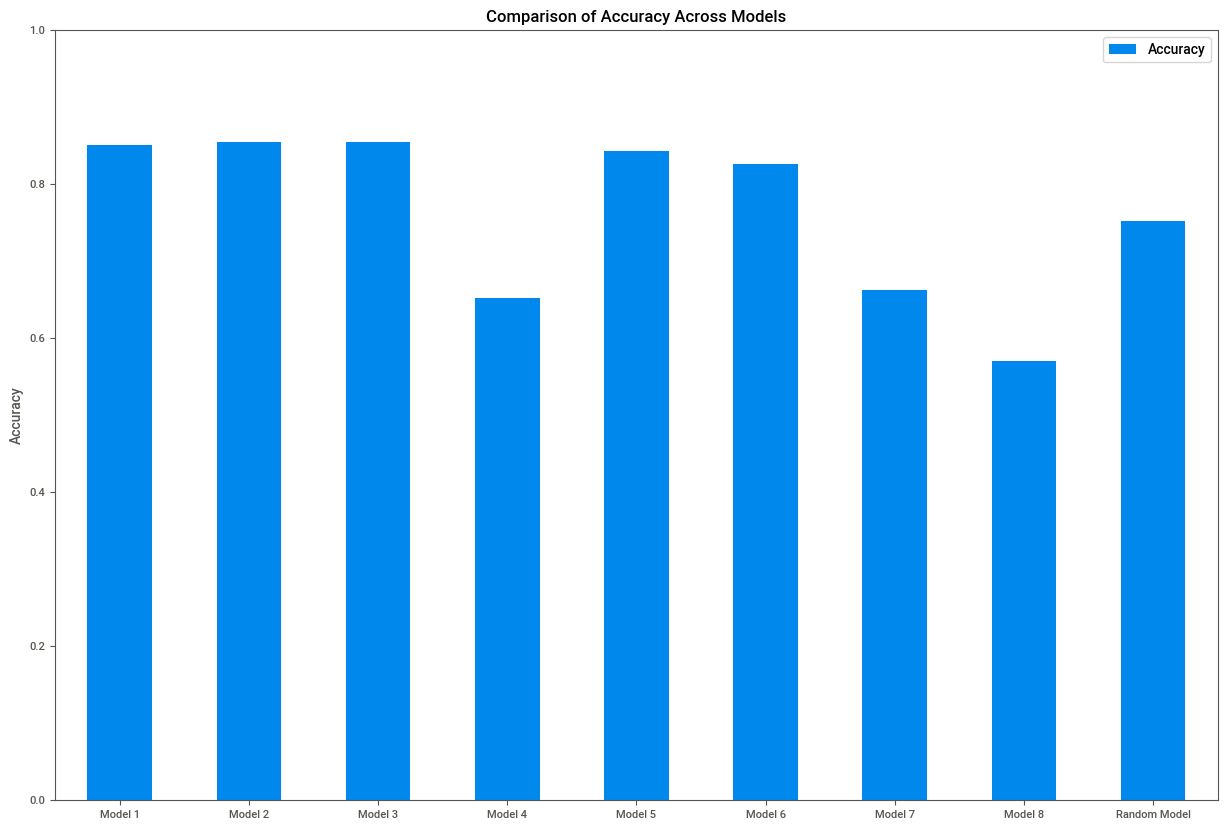

In [69]:
#Calculating accuracy for each model

accuracy_model1 = report_model1.loc['accuracy', 'precision']
accuracy_model2 = report_model2.loc['accuracy', 'precision']
accuracy_model3 = report_model3.loc['accuracy', 'precision']
accuracy_model4 = report_model4.loc['accuracy', 'precision']
accuracy_model5 = report_model5.loc['accuracy', 'precision']
accuracy_model6 = report_model6.loc['accuracy', 'precision']
accuracy_model7 = report_model7.loc['accuracy', 'precision']
accuracy_model8 = report_model8.loc['accuracy', 'precision']
accuracy_model_random = report_model_random.loc['accuracy', 'precision']
# Creating a dataframe for the accuracy of all models

accuracy_data = {
    "Model 1": accuracy_model1,
    "Model 2": accuracy_model2,
    "Model 3": accuracy_model3,
    "Model 4": accuracy_model4,
    "Model 5": accuracy_model5,
    "Model 6": accuracy_model6,
    "Model 7": accuracy_model7,
    "Model 8": accuracy_model8,
    "Random Model" : accuracy_model_random
}

df_accuracy = pd.DataFrame(list(accuracy_data.values()), index=accuracy_data.keys(), columns=["Accuracy"])

#Creating a bar chart to compare the accuracy of all models



fig, ax = plt.subplots(figsize=(15, 10))

df_accuracy.plot(kind='bar', ax=ax)
ax.set_title('Comparison of Accuracy Across Models')
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 1)
plt.xticks(rotation=0)
plt.show()

#Evaluate the chosen model (model 7) on test data


 We chose Model 7 because it demonstrated the best performance for predicting Class 1, which is the target variable we aim to predict.

Epoch 1/100
53/53 [==============================] - 1s 7ms/step - loss: 0.7422 - accuracy: 0.5203 - val_loss: 0.6766 - val_accuracy: 0.6195
Epoch 2/100
53/53 [==============================] - 0s 4ms/step - loss: 0.7207 - accuracy: 0.5060 - val_loss: 0.7004 - val_accuracy: 0.5206
Epoch 3/100
53/53 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.5609 - val_loss: 0.7104 - val_accuracy: 0.4971
Epoch 4/100
53/53 [==============================] - 0s 4ms/step - loss: 0.7023 - accuracy: 0.5573 - val_loss: 0.7197 - val_accuracy: 0.4808
Epoch 5/100
53/53 [==============================] - 0s 4ms/step - loss: 0.6787 - accuracy: 0.5692 - val_loss: 0.7205 - val_accuracy: 0.4912
Epoch 6/100
53/53 [==============================] - 0s 4ms/step - loss: 0.6819 - accuracy: 0.5632 - val_loss: 0.7154 - val_accuracy: 0.5074
Epoch 7/100
53/53 [==============================] - 0s 4ms/step - loss: 0.6781 - accuracy: 0.5859 - val_loss: 0.7077 - val_accuracy: 0.5251
Epoch 8/100
5

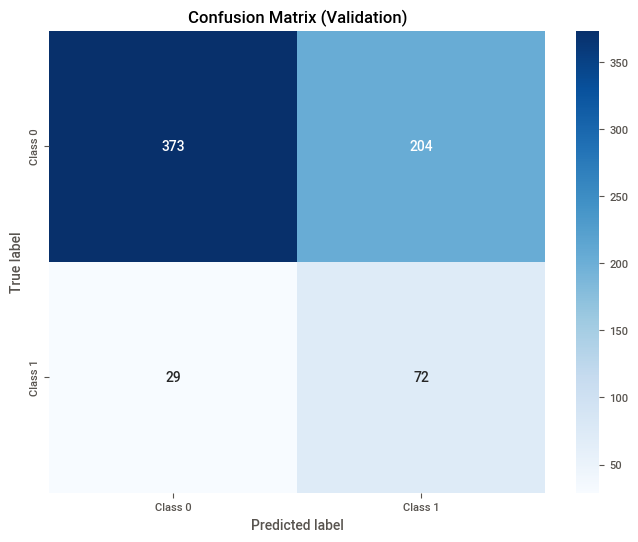

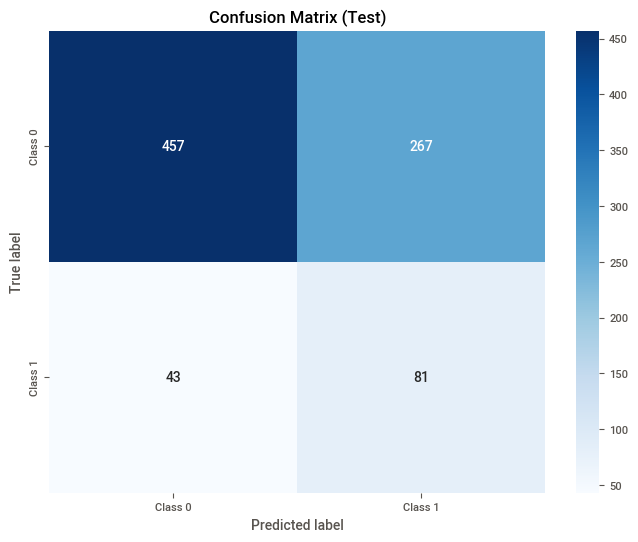

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.93      0.65      0.76       577
           1       0.26      0.71      0.38       101

    accuracy                           0.66       678
   macro avg       0.59      0.68      0.57       678
weighted avg       0.83      0.66      0.71       678

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.91      0.63      0.75       724
           1       0.23      0.65      0.34       124

    accuracy                           0.63       848
   macro avg       0.57      0.64      0.54       848
weighted avg       0.81      0.63      0.69       848



In [70]:

undersample = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_train_under, y_train_under = undersample.fit_resample(X_train_final, y_train_final)

# Define an enhanced model architecture
enhanced_model_under = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_under.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the enhanced model with a lower learning rate
enhanced_model_under.compile(optimizer=Adam(learning_rate=0.0001),
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

# Train the enhanced model with undersampled data
enhanced_history_under = enhanced_model_under.fit(X_train_under, y_train_under,
                                                  epochs=100,
                                                  batch_size=16,
                                                  validation_data=(X_val, y_val))

# Evaluate the enhanced model with undersampled data
enhanced_loss_under, enhanced_accuracy_under = enhanced_model_under.evaluate(X_test, y_test)
print(f'Test Accuracy of Enhanced Model with Undersampling: {enhanced_accuracy_under}')

# Predict on validation data with the enhanced model using undersampling
y_val_pred_enhanced_under = enhanced_model_under.predict(X_val)
y_val_pred_classes_enhanced_under = (y_val_pred_enhanced_under > 0.5).astype(int)

# Confusion matrix on validation data for the enhanced model using undersampling
cm_enhanced_under = confusion_matrix(y_val, y_val_pred_classes_enhanced_under)
print('Confusion Matrix (Validation):')
print(cm_enhanced_under)

# Classification report for the enhanced model using undersampling
class_report_7 = classification_report(y_val, y_val_pred_classes_enhanced_under)
print('Classification Report (Validation):')
print(class_report_7)

# Evaluate the enhanced model on test data
y_test_pred_enhanced_under = enhanced_model_under.predict(X_test)
y_test_pred_classes_enhanced_under = (y_test_pred_enhanced_under > 0.5).astype(int)

# Confusion matrix on test data for the enhanced model using undersampling
cm_enhanced_under_test = confusion_matrix(y_test, y_test_pred_classes_enhanced_under)

# Classification report for the enhanced model using undersampling on test data
class_report_7_test = classification_report(y_test, y_test_pred_classes_enhanced_under)

def plot_confusion_matrix(cm, title='Confusion Matrix', labels=['Class 0', 'Class 1']):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

#Displaying confusion matrices for validation and test sets
cm_val = confusion_matrix(y_val, y_val_pred_classes_enhanced_under)
cm_test = confusion_matrix(y_test, y_test_pred_classes_enhanced_under)

plot_confusion_matrix(cm_val, title='Confusion Matrix (Validation)')
plot_confusion_matrix(cm_test, title='Confusion Matrix (Test)')

# Displaying classification reports for validation and test sets
print("Classification Report (Validation):")
print(classification_report(y_val, y_val_pred_classes_enhanced_under))

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_classes_enhanced_under))


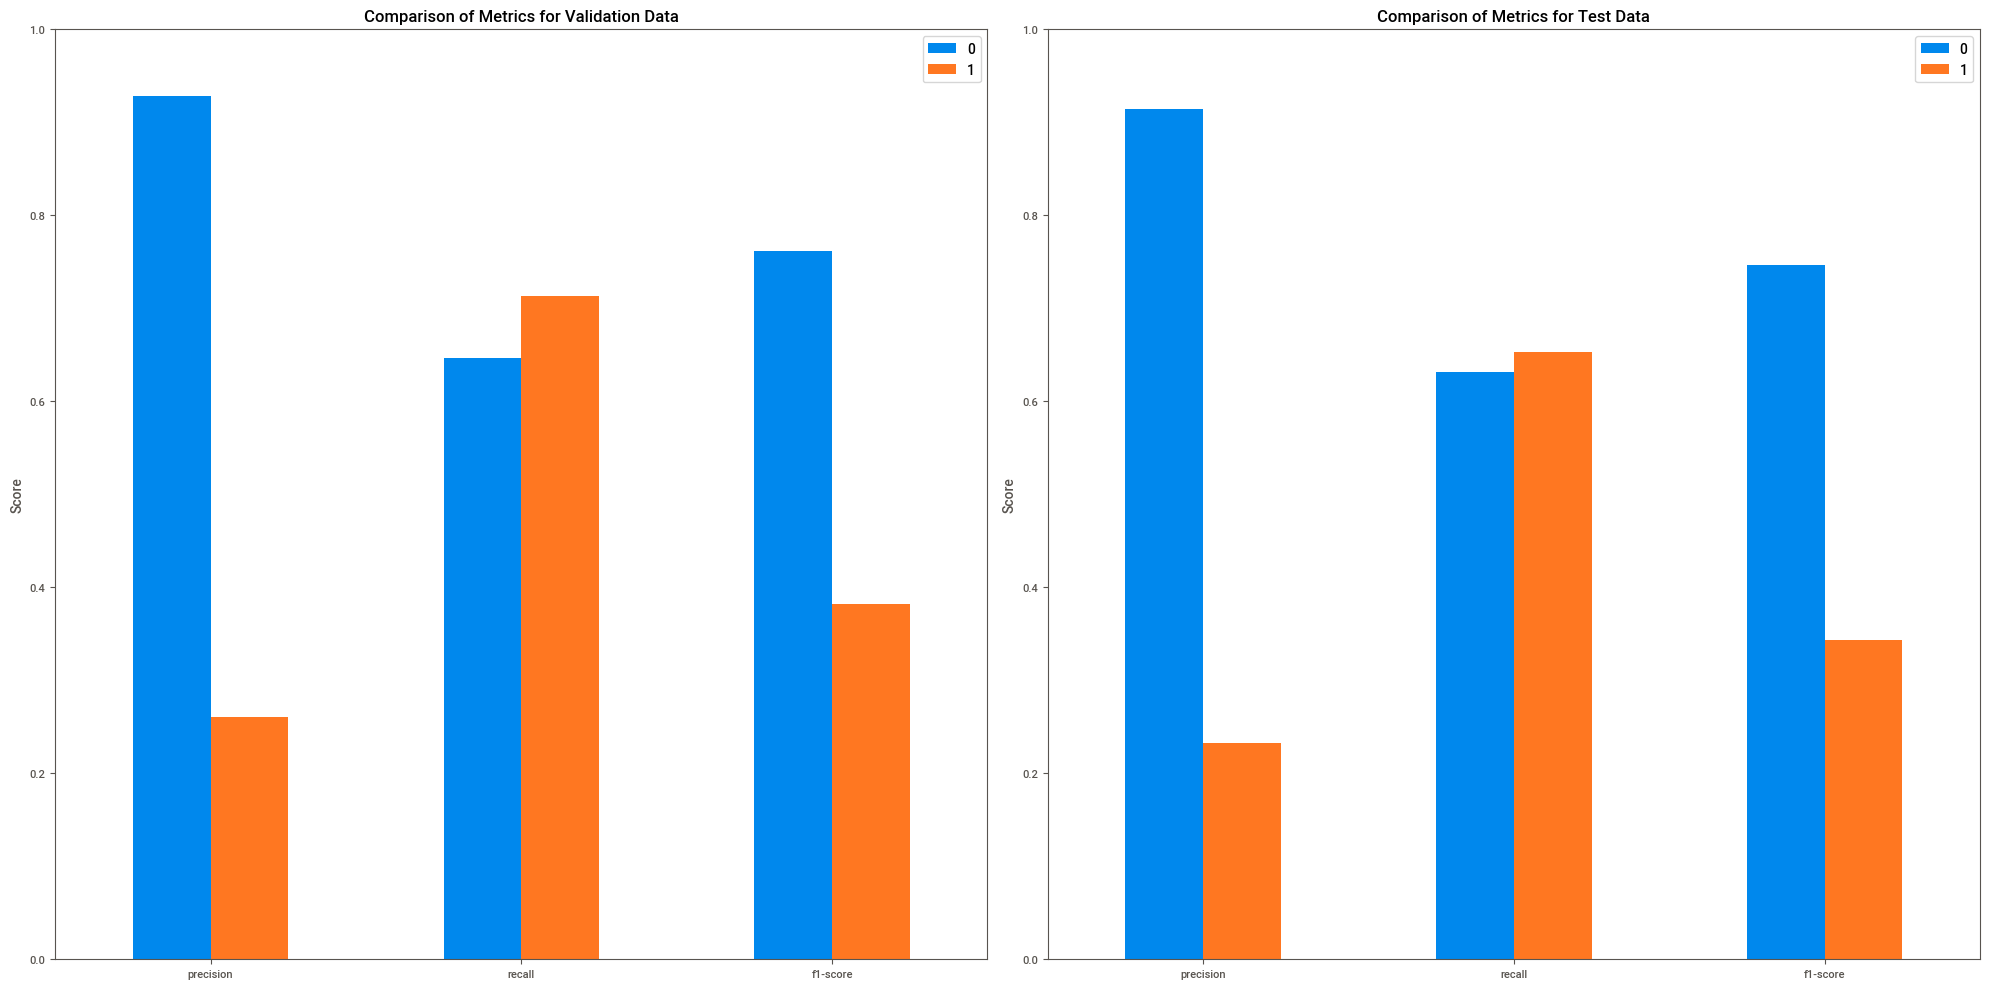

In [71]:

# Calculating metrics for validation and test data
report_val = get_classification_report_df(y_val, y_val_pred_classes_enhanced_under)
report_test = get_classification_report_df(y_test, y_test_pred_classes_enhanced_under)

#Selecting metrics to display for classes 0 and 1

metrics = ['precision', 'recall', 'f1-score']
classes = ['0', '1']

#Creating a bar chart to compare metrics for each class in validation and test data

val_reports = {cls: report_val.loc[cls, metrics] for cls in classes}
test_reports = {cls: report_test.loc[cls, metrics] for cls in classes}

#Creating a bar chart to compare metrics for each class in validation and test data

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

df_val_reports = pd.DataFrame(val_reports)
df_val_reports.plot(kind='bar', ax=axes[0])
axes[0].set_title('Comparison of Metrics for Validation Data')
axes[0].set_ylabel('Score')
axes[0].set_ylim(0, 1)
axes[0].set_xticklabels(metrics, rotation=0)

df_test_reports = pd.DataFrame(test_reports)
df_test_reports.plot(kind='bar', ax=axes[1])
axes[1].set_title('Comparison of Metrics for Test Data')
axes[1].set_ylabel('Score')
axes[1].set_ylim(0, 1)
axes[1].set_xticklabels(metrics, rotation=0)

plt.tight_layout()
plt.show()

**The results are sufficiently similar to assume that the model performs consistently on both the test and validation data.**